<a href="https://colab.research.google.com/github/chengchencon/HTML5Project/blob/main/Copy_of_FNO_3D_with_SDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Porous/

/content/drive/MyDrive/Porous


In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

#from Adam import Adam
from keras.optimizers import Adam

torch.manual_seed(0)
np.random.seed(0)

# New Section

In [5]:
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()
        
#in_channels : the number of input channels for the convolutional layer
#out_channels : the number of output channels for the convolutional layer
#modes123 : the modes to be used for the spectral normalization layer in each of the three dimensions

#mode : refers to the dimension along which an operation is applied for example
#in a 2d cnn layer, there might be modes of (height, width)
#in a 3d it is (depth, height, width)

#spectral normalization is a technique used to stabilize the training of deep neural networks
#normalizing the spectral norm of the weight matrix in each layer
#spectral norm is the largest singular value of a matrix


        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        # self.scale is to scale the weight matrix of the cnn layer during the spectral normalization
        # reciprocal : an inverse of a number : x-->1/x
        self.scale = (1 / (in_channels * out_channels))

        # initialized as a tensor of complex floating point values with (in_channels, .... self.mode3) using torch.rand
        # all values are being scaled by 'self.scale' to ensure that the weight matrix of the cnn layer is properly normalized during spectral normalization 
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication (2+3i)*(5-3i)
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        # high dimensions' multiplication, yeah!
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        # obtain the batchsize!!!
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        # performs an n-dimensional discrete DFT using the real input signal 'x', returns the n-dimensional complex output signal x_ft
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

In [6]:
import torch

x = torch.randn(4, 3)  # create a tensor with shape (4, 3, 28, 28)
x_flattened = x.view(2, 6)   # flatten the tensor to have shape (4, 2352)

print(x)
print(x_flattened)


tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820]])
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193, -0.4033, -0.5966,  0.1820]])


In [76]:
class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic

        # input tensor size : T_in+4 * self.width
        self.fc0 = nn.Linear(T_in+4, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        #x = self.bn0(x1 + x2)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        #x = self.bn1(x1 + x2)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        #x = self.bn2(x1 + x2)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        #x = self.bn3(x1 + x2)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
      # The grid is used to compute the positional encoding of the input tensor
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        # np.linspace(0, 1, size_x) an array of size_x and the inside numbers are between 0 and 1 [0, 0.3,0.6,1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        # 
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        # [batchsize, size_x, size_y, size_z, 3]
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

In [113]:
################################################################
# configs
################################################################

#TRAIN_PATH = '/content/drive/MyDrive/LBM_data/Sqst64_data_N2500_halfway.npy'
#/content/drive/MyDrive/LBM_data/sdf_array_sqst64_N2500.npy'
TRAIN_PATH = '/content/Mix256_data_N10_halfway.npy'


#ntrain = 2000
#ntest = 500
ntrain = 8
ntest = 2

modes = 8
width = 20

batch_size = 1
batch_size2 = batch_size

epochs = 400
learning_rate = 0.001
scheduler_step = 50
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'FNO3D_porousSDFnorm_sqst_halfway_GN_T_in1_rs30_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = '/content/'+path

path_train_err = '/content/'+path+'train.txt'
path_test_err = '/content/'+path+'test.txt'
path_image = '/content/image/'+path

runtime = np.zeros(2, )
t1 = default_timer()

sub = 1
#S = 64 // sub
S = 256
T_in = 1 # number of in slices. x time -> from 0 to step*T_in*dt
T = 29  # number of slices to predict. y time -> from step*T_in*dt to step*(T+T_in)*dt
step_tr = 1  # each step*dt time is taken as a slice
step_te = 4

400 0.001 50 0.5


In [114]:
data = np.load(TRAIN_PATH)
data = data.transpose(0, 2, 3, 1)
data.shape

(10, 256, 256, 50)

In [115]:
train_a = data[:ntrain, :, :, :T_in]
train_u = data[:ntrain, :, :, T_in:T+T_in]
test_a = data[ntrain: ntrain+ntest, :, :, :T_in]
test_u = data[ntrain: ntrain+ntest, :, :, T_in:T+T_in]

In [116]:
train_a = torch.Tensor(train_a)
train_u = torch.Tensor(train_u)
test_a = torch.Tensor(test_a)
test_u = torch.Tensor(test_u)

print(train_u.shape)

print(train_u.shape[-2])
print(train_u.shape[-1])
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

#a_normalizer = UnitGaussianNormalizer(train_a)
a_normalizer = GaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

#y_normalizer = UnitGaussianNormalizer(train_u)
y_normalizer = GaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

del data

torch.Size([8, 256, 256, 29])
256
29


In [117]:
train_a.shape, train_u.shape, test_a.shape, test_u.shape

(torch.Size([8, 256, 256, 1]),
 torch.Size([8, 256, 256, 29]),
 torch.Size([2, 256, 256, 1]),
 torch.Size([2, 256, 256, 29]))

In [118]:
sdf = np.load('/content/drive/MyDrive/LBM_data/sdf_array_mix256_N10.npy')
sdf.shape

(10, 256, 256)

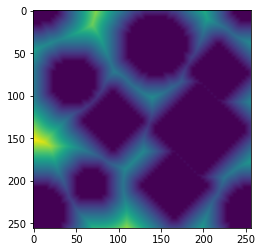

In [119]:
plt.imshow(sdf[0])

In [120]:
sdf[0][0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.66666667,  1.55555556,
        2.51851852,  3.50617284,  4.50205761,  5.50068587,  6.50022862,
        7.50007621,  8.5000254 ,  9.50000847, 10.50000282, 11.50000094,
       12.50000031, 13.5000001 , 14.50000003, 15.50000001, 16.5       ,
       17.5       , 18.5       , 19.5       , 20.5       , 21.5       ,
       22.5       , 23.5       , 24.5       , 25.5       , 26.5       ,
       27.5       , 28.5       , 29.5       , 30.5       , 31.5       ,
       32.5       , 33.5       , 34.5       , 35.5       , 36.5       ,
       37.5       , 38.5       , 39.5       , 40.5       , 41.5 

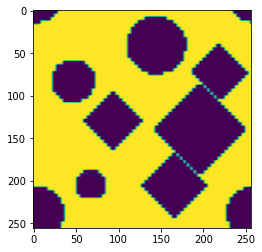

In [121]:

plt.imshow(train_a[0, :, :, 0])

In [122]:
sdf_train = torch.from_numpy(sdf[:ntrain])
# sdf_train from_numpy() creates a tensor from a numpy array without copying the data
sdf_test = torch.from_numpy(sdf[ntrain: ntrain+ntest])
print(sdf_train.shape)
print(sdf_test.shape)

torch.Size([8, 256, 256])
torch.Size([2, 256, 256])


In [123]:
sdf_a_normalizer = GaussianNormalizer(sdf_train)

In [124]:
sdf_train = sdf_a_normalizer.encode(sdf_train)
sdf_test = sdf_a_normalizer.encode(sdf_test)

In [125]:
sdf_train = sdf_train.unsqueeze(-1).float()
sdf_test = sdf_test.unsqueeze(-1).float()
sdf_train.shape, sdf_test.shape

(torch.Size([8, 256, 256, 1]), torch.Size([2, 256, 256, 1]))

In [126]:
train_a = torch.cat((train_a, sdf_train), -1)
test_a = torch.cat((test_a, sdf_test), -1)

In [127]:
train_a.shape, test_a.shape

(torch.Size([8, 256, 256, 2]), torch.Size([2, 256, 256, 2]))

In [128]:
train_a = train_a.reshape(ntrain,S,S,1,T_in+1).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in+1).repeat([1,1,1,T,1])

In [129]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

preprocessing finished, time used: 31.43706235899981


In [130]:
train_a.shape, train_u.shape, test_a.shape, test_u.shape

(torch.Size([8, 256, 256, 29, 2]),
 torch.Size([8, 256, 256, 29]),
 torch.Size([2, 256, 256, 29, 2]),
 torch.Size([2, 256, 256, 29]))

In [131]:
#del train_a, train_u
#del test_a, test_u

In [132]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
################################################################
# training and evaluation
################################################################

train_mse_arr = torch.tensor([])
test_l2_arr = torch.tensor([])
train_l2_arr = torch.tensor([])
epochs_done = 0

model = FNO3d(modes, modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
#optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma, verbose=True)

6558377
Adjusting learning rate of group 0 to 1.0000e-03.


In [100]:
# LOAD CHECKPOINT
checkpoint = torch.load(path_model+'.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epochs_done = checkpoint['epoch']

train_mse_arr = torch.load('final_results/loss/FNO3D_porousSDFnorm_sqst_halfway_GN_train_mse_arr_N2500_T_in1_rs30_m8_w24_l4')
train_l2_arr = torch.load('final_results/loss/FNO3D_porousSDFnorm_sqst_halfway_GN_train_l2_arr_N2500_T_in1_rs30_m8_w24_l4')
test_l2_arr = torch.load('final_results/loss/FNO3D_porousSDFnorm_sqst_halfway_GN_test_l2_arr_2500_T_in1_rs30_m8_w24_l4')

FileNotFoundError: ignored

In [134]:
torch.cuda.empty_cache()
for x, y in train_loader:
  op = model(x.cuda())
  break
x.shape, y.shape, op.shape

(torch.Size([1, 256, 256, 29, 2]),
 torch.Size([1, 256, 256, 29]),
 torch.Size([1, 256, 256, 29, 1]))

In [135]:
from torchinfo import summary
summary(model, input_size=(batch_size, 64, 64, 29, 2))

Layer (type:depth-idx)                   Output Shape              Param #
FNO3d                                    [1, 64, 64, 29, 1]        160
├─Linear: 1-1                            [1, 64, 64, 29, 20]       120
├─SpectralConv3d: 1-2                    [1, 20, 64, 64, 35]       819,200
├─Conv3d: 1-3                            [1, 20, 64, 64, 35]       420
├─SpectralConv3d: 1-4                    [1, 20, 64, 64, 35]       819,200
├─Conv3d: 1-5                            [1, 20, 64, 64, 35]       420
├─SpectralConv3d: 1-6                    [1, 20, 64, 64, 35]       819,200
├─Conv3d: 1-7                            [1, 20, 64, 64, 35]       420
├─SpectralConv3d: 1-8                    [1, 20, 64, 64, 35]       819,200
├─Conv3d: 1-9                            [1, 20, 64, 64, 35]       420
├─Linear: 1-10                           [1, 64, 64, 29, 128]      2,688
├─Linear: 1-11                           [1, 64, 64, 29, 1]        129
Total params: 3,281,577
Trainable params: 3,281,577
Non

In [136]:
from tqdm import tqdm

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in tqdm(range(epochs_done, epochs)):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        #print(out.shape)
        out = out.view(batch_size, S, S, T)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    train_mse_arr = torch.cat((train_mse_arr, torch.tensor([train_mse])), -1)
    train_l2_arr = torch.cat((train_l2_arr, torch.tensor([train_l2])), -1)
    test_l2_arr = torch.cat((test_l2_arr, torch.tensor([test_l2])), -1)

    t2 = default_timer()
    print(f'{ep}, {t2-t1:.2f}, {train_mse:.5f}, {train_l2:.5f}, {test_l2:.5f}')

    if ep%5 == 0:
      torch.save({
            'epoch': ep+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, path_model+'.pt')
      torch.save(train_mse_arr, '/content/FNO3D_porousSDFnorm_sqst_halfway_GN_train_mse_arr_N2500_T_in1_rs30_m8_w24_l4')
      torch.save(train_l2_arr, '/content/FNO3D_porousSDFnorm_sqst_halfway_GN_train_l2_arr_N2500_T_in1_rs30_m8_w24_l4')
      torch.save(test_l2_arr, '/content/FNO3D_porousSDFnorm_sqst_halfway_GN_test_l2_arr_2500_T_in1_rs30_m8_w24_l4')
      print(f'saved epoch {ep} successfully!')

  0%|          | 0/400 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 1/400 [00:08<53:29,  8.04s/it]

0, 7.90, 0.20497, 0.73687, 0.73152
saved epoch 0 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 2/400 [00:13<43:22,  6.54s/it]

1, 5.48, 0.19244, 0.71599, 0.70333
Adjusting learning rate of group 0 to 1.0000e-03.


  1%|          | 3/400 [00:19<40:16,  6.09s/it]

2, 5.55, 0.16061, 0.65351, 0.58072
Adjusting learning rate of group 0 to 1.0000e-03.


  1%|          | 4/400 [00:24<38:32,  5.84s/it]

3, 5.46, 0.10321, 0.52404, 0.48520
Adjusting learning rate of group 0 to 1.0000e-03.


  1%|▏         | 5/400 [00:30<37:46,  5.74s/it]

4, 5.55, 0.08089, 0.46395, 0.45646
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▏         | 6/400 [00:35<37:29,  5.71s/it]

5, 5.47, 0.06613, 0.42138, 0.43016
saved epoch 5 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▏         | 7/400 [00:41<36:59,  5.65s/it]

6, 5.52, 0.05485, 0.38310, 0.39943
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▏         | 8/400 [00:46<36:39,  5.61s/it]

7, 5.53, 0.04364, 0.34247, 0.36320
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▏         | 9/400 [00:52<36:14,  5.56s/it]

8, 5.45, 0.03500, 0.30625, 0.31834
Adjusting learning rate of group 0 to 1.0000e-03.


  2%|▎         | 10/400 [00:57<36:07,  5.56s/it]

9, 5.55, 0.02798, 0.27404, 0.28725
Adjusting learning rate of group 0 to 1.0000e-03.


  3%|▎         | 11/400 [01:03<36:06,  5.57s/it]

10, 5.43, 0.02234, 0.24425, 0.26259
saved epoch 10 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  3%|▎         | 12/400 [01:08<35:54,  5.55s/it]

11, 5.51, 0.01972, 0.22876, 0.25552
Adjusting learning rate of group 0 to 1.0000e-03.


  3%|▎         | 13/400 [01:14<35:46,  5.55s/it]

12, 5.52, 0.01606, 0.20785, 0.23596
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▎         | 14/400 [01:19<35:28,  5.51s/it]

13, 5.44, 0.01451, 0.19726, 0.22404
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 15/400 [01:25<35:29,  5.53s/it]

14, 5.57, 0.01222, 0.18115, 0.20506
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 16/400 [01:31<35:31,  5.55s/it]

15, 5.43, 0.01033, 0.16674, 0.19700
saved epoch 15 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 17/400 [01:36<36:06,  5.66s/it]

16, 5.90, 0.00887, 0.15425, 0.18380
Adjusting learning rate of group 0 to 1.0000e-03.


  4%|▍         | 18/400 [01:42<35:49,  5.63s/it]

17, 5.56, 0.00786, 0.14527, 0.17671
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▍         | 19/400 [01:47<35:24,  5.58s/it]

18, 5.46, 0.00713, 0.13828, 0.16886
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 20/400 [01:53<35:20,  5.58s/it]

19, 5.59, 0.00625, 0.12958, 0.16278
Adjusting learning rate of group 0 to 1.0000e-03.


  5%|▌         | 21/400 [01:59<35:17,  5.59s/it]

20, 5.44, 0.00556, 0.12218, 0.15650
saved epoch 20 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▌         | 22/400 [02:04<35:14,  5.59s/it]

21, 5.61, 0.00542, 0.12012, 0.15630
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▌         | 23/400 [02:10<34:54,  5.56s/it]

22, 5.47, 0.00535, 0.11962, 0.15067
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▌         | 24/400 [02:15<34:49,  5.56s/it]

23, 5.56, 0.00492, 0.11469, 0.15221
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▋         | 25/400 [02:21<34:40,  5.55s/it]

24, 5.52, 0.00545, 0.11906, 0.16141
Adjusting learning rate of group 0 to 1.0000e-03.


  6%|▋         | 26/400 [02:26<34:41,  5.56s/it]

25, 5.43, 0.00472, 0.11219, 0.14375
saved epoch 25 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  7%|▋         | 27/400 [02:32<34:42,  5.58s/it]

26, 5.62, 0.00451, 0.10851, 0.14542
Adjusting learning rate of group 0 to 1.0000e-03.


  7%|▋         | 28/400 [02:37<34:17,  5.53s/it]

27, 5.41, 0.00353, 0.09733, 0.13769
Adjusting learning rate of group 0 to 1.0000e-03.


  7%|▋         | 29/400 [02:43<34:15,  5.54s/it]

28, 5.55, 0.00333, 0.09450, 0.14431
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 30/400 [02:49<34:05,  5.53s/it]

29, 5.50, 0.00314, 0.09161, 0.13822
Adjusting learning rate of group 0 to 1.0000e-03.
30, 5.44, 0.00304, 0.08988, 0.13862


  8%|▊         | 31/400 [02:54<34:19,  5.58s/it]

saved epoch 30 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 32/400 [03:00<34:15,  5.58s/it]

31, 5.59, 0.00274, 0.08575, 0.13462
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 33/400 [03:05<33:58,  5.56s/it]

32, 5.49, 0.00290, 0.08759, 0.13896
Adjusting learning rate of group 0 to 1.0000e-03.


  8%|▊         | 34/400 [03:11<33:58,  5.57s/it]

33, 5.60, 0.00304, 0.09000, 0.14146
Adjusting learning rate of group 0 to 1.0000e-03.


  9%|▉         | 35/400 [03:16<33:38,  5.53s/it]

34, 5.44, 0.00346, 0.09574, 0.14795
Adjusting learning rate of group 0 to 1.0000e-03.
35, 5.57, 0.00313, 0.09138, 0.14069


  9%|▉         | 36/400 [03:22<34:06,  5.62s/it]

saved epoch 35 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


  9%|▉         | 37/400 [03:28<33:54,  5.60s/it]

36, 5.56, 0.00284, 0.08672, 0.13350
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|▉         | 38/400 [03:33<33:30,  5.56s/it]

37, 5.44, 0.00243, 0.08047, 0.13245
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|▉         | 39/400 [03:39<33:29,  5.57s/it]

38, 5.59, 0.00262, 0.08294, 0.13941
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 40/400 [03:44<33:08,  5.52s/it]

39, 5.43, 0.00247, 0.08118, 0.13060
Adjusting learning rate of group 0 to 1.0000e-03.
40, 5.55, 0.00228, 0.07799, 0.13283


 10%|█         | 41/400 [03:50<33:33,  5.61s/it]

saved epoch 40 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


 10%|█         | 42/400 [03:56<33:16,  5.58s/it]

41, 5.50, 0.00234, 0.07906, 0.13250
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|█         | 43/400 [04:01<32:59,  5.55s/it]

42, 5.47, 0.00223, 0.07728, 0.12831
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|█         | 44/400 [04:07<33:16,  5.61s/it]

43, 5.75, 0.00220, 0.07664, 0.13370
Adjusting learning rate of group 0 to 1.0000e-03.


 11%|█▏        | 45/400 [04:12<32:55,  5.57s/it]

44, 5.47, 0.00216, 0.07589, 0.13050
Adjusting learning rate of group 0 to 1.0000e-03.
45, 5.57, 0.00211, 0.07513, 0.13254


 12%|█▏        | 46/400 [04:18<33:18,  5.65s/it]

saved epoch 45 successfully!
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▏        | 47/400 [04:24<33:00,  5.61s/it]

46, 5.52, 0.00235, 0.07874, 0.13613
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▏        | 48/400 [04:29<32:44,  5.58s/it]

47, 5.51, 0.00230, 0.07851, 0.13207
Adjusting learning rate of group 0 to 1.0000e-03.


 12%|█▏        | 49/400 [04:35<32:36,  5.57s/it]

48, 5.55, 0.00230, 0.07851, 0.13084
Adjusting learning rate of group 0 to 5.0000e-04.


 12%|█▎        | 50/400 [04:40<32:17,  5.54s/it]

49, 5.45, 0.00198, 0.07291, 0.12961
Adjusting learning rate of group 0 to 5.0000e-04.


 13%|█▎        | 51/400 [04:46<32:31,  5.59s/it]

50, 5.56, 0.00169, 0.06727, 0.12671
saved epoch 50 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 13%|█▎        | 52/400 [04:51<32:13,  5.56s/it]

51, 5.45, 0.00149, 0.06317, 0.12464
Adjusting learning rate of group 0 to 5.0000e-04.


 13%|█▎        | 53/400 [04:57<32:05,  5.55s/it]

52, 5.53, 0.00138, 0.06088, 0.12643
Adjusting learning rate of group 0 to 5.0000e-04.


 14%|█▎        | 54/400 [05:02<31:55,  5.54s/it]

53, 5.50, 0.00132, 0.05954, 0.12589
Adjusting learning rate of group 0 to 5.0000e-04.


 14%|█▍        | 55/400 [05:08<31:43,  5.52s/it]

54, 5.47, 0.00125, 0.05796, 0.12507
Adjusting learning rate of group 0 to 5.0000e-04.


 14%|█▍        | 56/400 [05:14<32:02,  5.59s/it]

55, 5.59, 0.00123, 0.05737, 0.12607
saved epoch 55 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 14%|█▍        | 57/400 [05:19<31:44,  5.55s/it]

56, 5.46, 0.00120, 0.05678, 0.12602
Adjusting learning rate of group 0 to 5.0000e-04.


 14%|█▍        | 58/400 [05:25<31:38,  5.55s/it]

57, 5.55, 0.00118, 0.05637, 0.12658
Adjusting learning rate of group 0 to 5.0000e-04.


 15%|█▍        | 59/400 [05:30<31:29,  5.54s/it]

58, 5.51, 0.00115, 0.05561, 0.12691
Adjusting learning rate of group 0 to 5.0000e-04.


 15%|█▌        | 60/400 [05:36<31:11,  5.51s/it]

59, 5.42, 0.00113, 0.05497, 0.12639
Adjusting learning rate of group 0 to 5.0000e-04.


 15%|█▌        | 61/400 [05:41<31:28,  5.57s/it]

60, 5.53, 0.00112, 0.05477, 0.12717
saved epoch 60 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 16%|█▌        | 62/400 [05:47<31:10,  5.53s/it]

61, 5.44, 0.00112, 0.05475, 0.12747
Adjusting learning rate of group 0 to 5.0000e-04.


 16%|█▌        | 63/400 [05:52<31:08,  5.55s/it]

62, 5.57, 0.00112, 0.05476, 0.12761
Adjusting learning rate of group 0 to 5.0000e-04.


 16%|█▌        | 64/400 [05:58<30:56,  5.53s/it]

63, 5.48, 0.00108, 0.05391, 0.12673
Adjusting learning rate of group 0 to 5.0000e-04.


 16%|█▋        | 65/400 [06:03<30:47,  5.52s/it]

64, 5.49, 0.00106, 0.05325, 0.12849
Adjusting learning rate of group 0 to 5.0000e-04.


 16%|█▋        | 66/400 [06:09<31:08,  5.59s/it]

65, 5.57, 0.00104, 0.05286, 0.12700
saved epoch 65 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 17%|█▋        | 67/400 [06:14<30:45,  5.54s/it]

66, 5.42, 0.00103, 0.05267, 0.12899
Adjusting learning rate of group 0 to 5.0000e-04.


 17%|█▋        | 68/400 [06:20<30:47,  5.57s/it]

67, 5.62, 0.00103, 0.05257, 0.12741
Adjusting learning rate of group 0 to 5.0000e-04.


 17%|█▋        | 69/400 [06:25<30:28,  5.52s/it]

68, 5.43, 0.00102, 0.05232, 0.12908
Adjusting learning rate of group 0 to 5.0000e-04.


 18%|█▊        | 70/400 [06:31<30:29,  5.54s/it]

69, 5.59, 0.00105, 0.05315, 0.12809
Adjusting learning rate of group 0 to 5.0000e-04.


 18%|█▊        | 71/400 [06:37<30:37,  5.58s/it]

70, 5.48, 0.00107, 0.05359, 0.13043
saved epoch 70 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 18%|█▊        | 72/400 [06:42<30:21,  5.55s/it]

71, 5.48, 0.00111, 0.05452, 0.12973
Adjusting learning rate of group 0 to 5.0000e-04.


 18%|█▊        | 73/400 [06:48<30:21,  5.57s/it]

72, 5.61, 0.00110, 0.05438, 0.13089
Adjusting learning rate of group 0 to 5.0000e-04.


 18%|█▊        | 74/400 [06:53<30:03,  5.53s/it]

73, 5.44, 0.00106, 0.05338, 0.12853
Adjusting learning rate of group 0 to 5.0000e-04.


 19%|█▉        | 75/400 [06:59<30:04,  5.55s/it]

74, 5.59, 0.00110, 0.05424, 0.13001
Adjusting learning rate of group 0 to 5.0000e-04.


 19%|█▉        | 76/400 [07:05<30:07,  5.58s/it]

75, 5.46, 0.00112, 0.05465, 0.13117
saved epoch 75 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 19%|█▉        | 77/400 [07:10<29:59,  5.57s/it]

76, 5.55, 0.00115, 0.05542, 0.12918
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|█▉        | 78/400 [07:16<29:51,  5.56s/it]

77, 5.54, 0.00111, 0.05470, 0.13156
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|█▉        | 79/400 [07:21<29:35,  5.53s/it]

78, 5.46, 0.00111, 0.05447, 0.12848
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|██        | 80/400 [07:27<29:36,  5.55s/it]

79, 5.60, 0.00112, 0.05455, 0.13075
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|██        | 81/400 [07:32<29:38,  5.58s/it]

80, 5.47, 0.00115, 0.05539, 0.13062
saved epoch 80 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 20%|██        | 82/400 [07:38<29:27,  5.56s/it]

81, 5.51, 0.00128, 0.05849, 0.13114
Adjusting learning rate of group 0 to 5.0000e-04.


 21%|██        | 83/400 [07:43<29:18,  5.55s/it]

82, 5.52, 0.00110, 0.05437, 0.12901
Adjusting learning rate of group 0 to 5.0000e-04.


 21%|██        | 84/400 [07:49<29:05,  5.52s/it]

83, 5.46, 0.00113, 0.05492, 0.13019
Adjusting learning rate of group 0 to 5.0000e-04.


 21%|██▏       | 85/400 [07:54<29:06,  5.54s/it]

84, 5.59, 0.00110, 0.05431, 0.12767
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▏       | 86/400 [08:00<29:12,  5.58s/it]

85, 5.49, 0.00106, 0.05333, 0.12943
saved epoch 85 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▏       | 87/400 [08:06<29:06,  5.58s/it]

86, 5.57, 0.00103, 0.05253, 0.12954
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▏       | 88/400 [08:11<28:50,  5.55s/it]

87, 5.47, 0.00101, 0.05206, 0.12967
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▏       | 89/400 [08:17<28:39,  5.53s/it]

88, 5.48, 0.00101, 0.05196, 0.12930
Adjusting learning rate of group 0 to 5.0000e-04.


 22%|██▎       | 90/400 [08:22<28:35,  5.54s/it]

89, 5.55, 0.00102, 0.05218, 0.12970
Adjusting learning rate of group 0 to 5.0000e-04.


 23%|██▎       | 91/400 [08:28<28:40,  5.57s/it]

90, 5.48, 0.00103, 0.05235, 0.12871
saved epoch 90 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 23%|██▎       | 92/400 [08:33<28:35,  5.57s/it]

91, 5.57, 0.00108, 0.05335, 0.12809
Adjusting learning rate of group 0 to 5.0000e-04.


 23%|██▎       | 93/400 [08:39<28:15,  5.52s/it]

92, 5.42, 0.00101, 0.05191, 0.13137
Adjusting learning rate of group 0 to 5.0000e-04.


 24%|██▎       | 94/400 [08:44<28:14,  5.54s/it]

93, 5.57, 0.00107, 0.05328, 0.12900
Adjusting learning rate of group 0 to 5.0000e-04.


 24%|██▍       | 95/400 [08:50<28:07,  5.53s/it]

94, 5.51, 0.00111, 0.05440, 0.12862
Adjusting learning rate of group 0 to 5.0000e-04.
95, 5.49, 0.00106, 0.05334, 0.13073


 24%|██▍       | 96/400 [08:56<28:16,  5.58s/it]

saved epoch 95 successfully!
Adjusting learning rate of group 0 to 5.0000e-04.


 24%|██▍       | 97/400 [09:01<28:18,  5.61s/it]

96, 5.66, 0.00107, 0.05363, 0.12880
Adjusting learning rate of group 0 to 5.0000e-04.


 24%|██▍       | 98/400 [09:07<27:59,  5.56s/it]

97, 5.45, 0.00120, 0.05677, 0.12888
Adjusting learning rate of group 0 to 5.0000e-04.


 25%|██▍       | 99/400 [09:12<27:55,  5.57s/it]

98, 5.58, 0.00119, 0.05665, 0.13179
Adjusting learning rate of group 0 to 2.5000e-04.


 25%|██▌       | 100/400 [09:18<27:45,  5.55s/it]

99, 5.51, 0.00134, 0.05959, 0.12873
Adjusting learning rate of group 0 to 2.5000e-04.
100, 5.44, 0.00113, 0.05491, 0.12885


 25%|██▌       | 101/400 [09:23<27:52,  5.59s/it]

saved epoch 100 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 26%|██▌       | 102/400 [09:29<27:48,  5.60s/it]

101, 5.61, 0.00095, 0.05042, 0.12963
Adjusting learning rate of group 0 to 2.5000e-04.


 26%|██▌       | 103/400 [09:35<27:30,  5.56s/it]

102, 5.46, 0.00092, 0.04959, 0.12821
Adjusting learning rate of group 0 to 2.5000e-04.


 26%|██▌       | 104/400 [09:40<27:26,  5.56s/it]

103, 5.58, 0.00088, 0.04848, 0.12676
Adjusting learning rate of group 0 to 2.5000e-04.


 26%|██▋       | 105/400 [09:46<27:08,  5.52s/it]

104, 5.42, 0.00085, 0.04769, 0.12834
Adjusting learning rate of group 0 to 2.5000e-04.
105, 5.54, 0.00081, 0.04673, 0.12813


 26%|██▋       | 106/400 [09:51<27:26,  5.60s/it]

saved epoch 105 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 27%|██▋       | 107/400 [09:57<27:18,  5.59s/it]

106, 5.57, 0.00079, 0.04616, 0.12808
Adjusting learning rate of group 0 to 2.5000e-04.


 27%|██▋       | 108/400 [10:02<27:02,  5.56s/it]

107, 5.47, 0.00079, 0.04594, 0.12755
Adjusting learning rate of group 0 to 2.5000e-04.


 27%|██▋       | 109/400 [10:08<26:59,  5.57s/it]

108, 5.58, 0.00078, 0.04564, 0.12853
Adjusting learning rate of group 0 to 2.5000e-04.


 28%|██▊       | 110/400 [10:13<26:45,  5.54s/it]

109, 5.47, 0.00077, 0.04545, 0.12842
Adjusting learning rate of group 0 to 2.5000e-04.
110, 5.54, 0.00076, 0.04519, 0.12855


 28%|██▊       | 111/400 [10:19<27:00,  5.61s/it]

saved epoch 110 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 28%|██▊       | 112/400 [10:25<26:46,  5.58s/it]

111, 5.51, 0.00076, 0.04507, 0.12844
Adjusting learning rate of group 0 to 2.5000e-04.


 28%|██▊       | 113/400 [10:30<26:29,  5.54s/it]

112, 5.45, 0.00075, 0.04493, 0.12850
Adjusting learning rate of group 0 to 2.5000e-04.


 28%|██▊       | 114/400 [10:36<26:34,  5.58s/it]

113, 5.66, 0.00074, 0.04471, 0.12868
Adjusting learning rate of group 0 to 2.5000e-04.


 29%|██▉       | 115/400 [10:41<26:17,  5.54s/it]

114, 5.44, 0.00074, 0.04461, 0.12899
Adjusting learning rate of group 0 to 2.5000e-04.
115, 5.64, 0.00074, 0.04448, 0.12888


 29%|██▉       | 116/400 [10:47<26:41,  5.64s/it]

saved epoch 115 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 29%|██▉       | 117/400 [10:53<26:17,  5.57s/it]

116, 5.42, 0.00073, 0.04431, 0.12924
Adjusting learning rate of group 0 to 2.5000e-04.


 30%|██▉       | 118/400 [10:58<26:04,  5.55s/it]

117, 5.49, 0.00073, 0.04426, 0.12898
Adjusting learning rate of group 0 to 2.5000e-04.


 30%|██▉       | 119/400 [11:04<26:02,  5.56s/it]

118, 5.58, 0.00073, 0.04415, 0.12940
Adjusting learning rate of group 0 to 2.5000e-04.


 30%|███       | 120/400 [11:09<25:47,  5.53s/it]

119, 5.44, 0.00072, 0.04402, 0.12932
Adjusting learning rate of group 0 to 2.5000e-04.


 30%|███       | 121/400 [11:15<26:05,  5.61s/it]

120, 5.61, 0.00072, 0.04391, 0.12950
saved epoch 120 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 30%|███       | 122/400 [11:20<25:47,  5.57s/it]

121, 5.47, 0.00071, 0.04380, 0.12965
Adjusting learning rate of group 0 to 2.5000e-04.


 31%|███       | 123/400 [11:26<25:41,  5.57s/it]

122, 5.56, 0.00071, 0.04366, 0.12965
Adjusting learning rate of group 0 to 2.5000e-04.


 31%|███       | 124/400 [11:31<25:32,  5.55s/it]

123, 5.51, 0.00071, 0.04359, 0.12991
Adjusting learning rate of group 0 to 2.5000e-04.


 31%|███▏      | 125/400 [11:37<25:18,  5.52s/it]

124, 5.45, 0.00070, 0.04346, 0.12988
Adjusting learning rate of group 0 to 2.5000e-04.


 32%|███▏      | 126/400 [11:43<25:34,  5.60s/it]

125, 5.60, 0.00070, 0.04332, 0.12988
saved epoch 125 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 32%|███▏      | 127/400 [11:48<25:17,  5.56s/it]

126, 5.46, 0.00070, 0.04325, 0.12995
Adjusting learning rate of group 0 to 2.5000e-04.


 32%|███▏      | 128/400 [11:54<25:15,  5.57s/it]

127, 5.60, 0.00069, 0.04307, 0.13010
Adjusting learning rate of group 0 to 2.5000e-04.


 32%|███▏      | 129/400 [11:59<25:02,  5.54s/it]

128, 5.47, 0.00069, 0.04299, 0.13027
Adjusting learning rate of group 0 to 2.5000e-04.


 32%|███▎      | 130/400 [12:05<24:50,  5.52s/it]

129, 5.47, 0.00069, 0.04290, 0.13050
Adjusting learning rate of group 0 to 2.5000e-04.


 33%|███▎      | 131/400 [12:10<25:03,  5.59s/it]

130, 5.56, 0.00068, 0.04283, 0.13025
saved epoch 130 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 33%|███▎      | 132/400 [12:16<24:48,  5.56s/it]

131, 5.47, 0.00068, 0.04272, 0.13046
Adjusting learning rate of group 0 to 2.5000e-04.


 33%|███▎      | 133/400 [12:22<24:46,  5.57s/it]

132, 5.59, 0.00067, 0.04255, 0.13067
Adjusting learning rate of group 0 to 2.5000e-04.


 34%|███▎      | 134/400 [12:27<24:32,  5.54s/it]

133, 5.46, 0.00067, 0.04244, 0.13079
Adjusting learning rate of group 0 to 2.5000e-04.


 34%|███▍      | 135/400 [12:32<24:23,  5.52s/it]

134, 5.49, 0.00067, 0.04240, 0.13071
Adjusting learning rate of group 0 to 2.5000e-04.


 34%|███▍      | 136/400 [12:38<24:34,  5.59s/it]

135, 5.57, 0.00067, 0.04230, 0.13092
saved epoch 135 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 34%|███▍      | 137/400 [12:44<24:17,  5.54s/it]

136, 5.43, 0.00066, 0.04222, 0.13095
Adjusting learning rate of group 0 to 2.5000e-04.


 34%|███▍      | 138/400 [12:49<24:15,  5.56s/it]

137, 5.59, 0.00066, 0.04212, 0.13102
Adjusting learning rate of group 0 to 2.5000e-04.


 35%|███▍      | 139/400 [12:55<24:00,  5.52s/it]

138, 5.43, 0.00066, 0.04199, 0.13125
Adjusting learning rate of group 0 to 2.5000e-04.


 35%|███▌      | 140/400 [13:00<23:56,  5.53s/it]

139, 5.54, 0.00066, 0.04194, 0.13110
Adjusting learning rate of group 0 to 2.5000e-04.


 35%|███▌      | 141/400 [13:06<24:03,  5.58s/it]

140, 5.52, 0.00065, 0.04183, 0.13155
saved epoch 140 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 36%|███▌      | 142/400 [13:11<23:51,  5.55s/it]

141, 5.49, 0.00065, 0.04173, 0.13117
Adjusting learning rate of group 0 to 2.5000e-04.


 36%|███▌      | 143/400 [13:17<23:51,  5.57s/it]

142, 5.61, 0.00065, 0.04176, 0.13206
Adjusting learning rate of group 0 to 2.5000e-04.


 36%|███▌      | 144/400 [13:22<23:36,  5.53s/it]

143, 5.45, 0.00065, 0.04174, 0.13094
Adjusting learning rate of group 0 to 2.5000e-04.


 36%|███▋      | 145/400 [13:28<23:39,  5.56s/it]

144, 5.64, 0.00065, 0.04169, 0.13227
Adjusting learning rate of group 0 to 2.5000e-04.


 36%|███▋      | 146/400 [13:34<23:38,  5.58s/it]

145, 5.43, 0.00065, 0.04176, 0.13125
saved epoch 145 successfully!
Adjusting learning rate of group 0 to 2.5000e-04.


 37%|███▋      | 147/400 [13:39<23:31,  5.58s/it]

146, 5.56, 0.00065, 0.04171, 0.13243
Adjusting learning rate of group 0 to 2.5000e-04.


 37%|███▋      | 148/400 [13:45<23:23,  5.57s/it]

147, 5.55, 0.00066, 0.04200, 0.13178
Adjusting learning rate of group 0 to 2.5000e-04.


 37%|███▋      | 149/400 [13:50<23:09,  5.53s/it]

148, 5.45, 0.00067, 0.04232, 0.13263
Adjusting learning rate of group 0 to 1.2500e-04.


 38%|███▊      | 150/400 [13:56<23:05,  5.54s/it]

149, 5.55, 0.00069, 0.04317, 0.13219
Adjusting learning rate of group 0 to 1.2500e-04.


 38%|███▊      | 151/400 [14:01<23:07,  5.57s/it]

150, 5.46, 0.00072, 0.04406, 0.13261
saved epoch 150 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 38%|███▊      | 152/400 [14:07<22:59,  5.56s/it]

151, 5.54, 0.00067, 0.04229, 0.13208
Adjusting learning rate of group 0 to 1.2500e-04.


 38%|███▊      | 153/400 [14:13<22:50,  5.55s/it]

152, 5.51, 0.00065, 0.04177, 0.13152
Adjusting learning rate of group 0 to 1.2500e-04.


 38%|███▊      | 154/400 [14:18<22:38,  5.52s/it]

153, 5.46, 0.00063, 0.04121, 0.13194
Adjusting learning rate of group 0 to 1.2500e-04.


 39%|███▉      | 155/400 [14:24<22:37,  5.54s/it]

154, 5.59, 0.00062, 0.04092, 0.13233
Adjusting learning rate of group 0 to 1.2500e-04.


 39%|███▉      | 156/400 [14:29<22:38,  5.57s/it]

155, 5.43, 0.00062, 0.04070, 0.13181
saved epoch 155 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 39%|███▉      | 157/400 [14:35<22:36,  5.58s/it]

156, 5.62, 0.00061, 0.04053, 0.13207
Adjusting learning rate of group 0 to 1.2500e-04.


 40%|███▉      | 158/400 [14:40<22:22,  5.55s/it]

157, 5.46, 0.00061, 0.04045, 0.13210
Adjusting learning rate of group 0 to 1.2500e-04.


 40%|███▉      | 159/400 [14:46<22:15,  5.54s/it]

158, 5.52, 0.00061, 0.04033, 0.13221
Adjusting learning rate of group 0 to 1.2500e-04.


 40%|████      | 160/400 [14:51<22:14,  5.56s/it]

159, 5.60, 0.00060, 0.04026, 0.13193
Adjusting learning rate of group 0 to 1.2500e-04.


 40%|████      | 161/400 [14:57<22:13,  5.58s/it]

160, 5.43, 0.00060, 0.04020, 0.13241
saved epoch 160 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 40%|████      | 162/400 [15:03<22:10,  5.59s/it]

161, 5.60, 0.00060, 0.04012, 0.13218
Adjusting learning rate of group 0 to 1.2500e-04.


 41%|████      | 163/400 [15:08<21:54,  5.55s/it]

162, 5.45, 0.00060, 0.04005, 0.13229
Adjusting learning rate of group 0 to 1.2500e-04.


 41%|████      | 164/400 [15:14<21:50,  5.55s/it]

163, 5.56, 0.00060, 0.04000, 0.13245
Adjusting learning rate of group 0 to 1.2500e-04.


 41%|████▏     | 165/400 [15:19<21:42,  5.54s/it]

164, 5.51, 0.00059, 0.03992, 0.13244
Adjusting learning rate of group 0 to 1.2500e-04.


 42%|████▏     | 166/400 [15:25<21:44,  5.58s/it]

165, 5.46, 0.00059, 0.03987, 0.13242
saved epoch 165 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 42%|████▏     | 167/400 [15:30<21:38,  5.57s/it]

166, 5.56, 0.00059, 0.03983, 0.13265
Adjusting learning rate of group 0 to 1.2500e-04.


 42%|████▏     | 168/400 [15:36<21:24,  5.53s/it]

167, 5.45, 0.00059, 0.03978, 0.13248
Adjusting learning rate of group 0 to 1.2500e-04.


 42%|████▏     | 169/400 [15:41<21:21,  5.55s/it]

168, 5.58, 0.00059, 0.03968, 0.13266
Adjusting learning rate of group 0 to 1.2500e-04.


 42%|████▎     | 170/400 [15:47<21:09,  5.52s/it]

169, 5.44, 0.00059, 0.03963, 0.13281
Adjusting learning rate of group 0 to 1.2500e-04.
170, 5.48, 0.00058, 0.03959, 0.13274


 43%|████▎     | 171/400 [15:53<21:19,  5.59s/it]

saved epoch 170 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 43%|████▎     | 172/400 [15:58<21:15,  5.60s/it]

171, 5.61, 0.00058, 0.03952, 0.13278
Adjusting learning rate of group 0 to 1.2500e-04.


 43%|████▎     | 173/400 [16:04<20:58,  5.54s/it]

172, 5.42, 0.00058, 0.03946, 0.13302
Adjusting learning rate of group 0 to 1.2500e-04.


 44%|████▎     | 174/400 [16:09<20:53,  5.55s/it]

173, 5.55, 0.00058, 0.03941, 0.13282
Adjusting learning rate of group 0 to 1.2500e-04.


 44%|████▍     | 175/400 [16:15<20:41,  5.52s/it]

174, 5.45, 0.00058, 0.03937, 0.13306
Adjusting learning rate of group 0 to 1.2500e-04.
175, 5.53, 0.00058, 0.03930, 0.13301


 44%|████▍     | 176/400 [16:20<20:52,  5.59s/it]

saved epoch 175 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 44%|████▍     | 177/400 [16:26<20:44,  5.58s/it]

176, 5.55, 0.00057, 0.03926, 0.13320
Adjusting learning rate of group 0 to 1.2500e-04.


 44%|████▍     | 178/400 [16:31<20:29,  5.54s/it]

177, 5.44, 0.00057, 0.03918, 0.13320
Adjusting learning rate of group 0 to 1.2500e-04.


 45%|████▍     | 179/400 [16:37<20:28,  5.56s/it]

178, 5.60, 0.00057, 0.03912, 0.13330
Adjusting learning rate of group 0 to 1.2500e-04.


 45%|████▌     | 180/400 [16:43<20:15,  5.53s/it]

179, 5.45, 0.00057, 0.03907, 0.13324
Adjusting learning rate of group 0 to 1.2500e-04.
180, 5.57, 0.00057, 0.03901, 0.13336


 45%|████▌     | 181/400 [16:48<20:28,  5.61s/it]

saved epoch 180 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 46%|████▌     | 182/400 [16:54<20:14,  5.57s/it]

181, 5.48, 0.00057, 0.03897, 0.13336
Adjusting learning rate of group 0 to 1.2500e-04.


 46%|████▌     | 183/400 [16:59<20:05,  5.55s/it]

182, 5.51, 0.00056, 0.03893, 0.13348
Adjusting learning rate of group 0 to 1.2500e-04.


 46%|████▌     | 184/400 [17:05<20:05,  5.58s/it]

183, 5.63, 0.00056, 0.03886, 0.13347
Adjusting learning rate of group 0 to 1.2500e-04.


 46%|████▋     | 185/400 [17:10<19:51,  5.54s/it]

184, 5.46, 0.00056, 0.03880, 0.13361
Adjusting learning rate of group 0 to 1.2500e-04.


 46%|████▋     | 186/400 [17:16<20:01,  5.61s/it]

185, 5.58, 0.00056, 0.03877, 0.13361
saved epoch 185 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 47%|████▋     | 187/400 [17:22<19:45,  5.57s/it]

186, 5.45, 0.00056, 0.03869, 0.13387
Adjusting learning rate of group 0 to 1.2500e-04.


 47%|████▋     | 188/400 [17:27<19:37,  5.55s/it]

187, 5.53, 0.00056, 0.03863, 0.13360
Adjusting learning rate of group 0 to 1.2500e-04.


 47%|████▋     | 189/400 [17:33<19:33,  5.56s/it]

188, 5.57, 0.00056, 0.03861, 0.13387
Adjusting learning rate of group 0 to 1.2500e-04.


 48%|████▊     | 190/400 [17:38<19:20,  5.53s/it]

189, 5.44, 0.00055, 0.03857, 0.13398
Adjusting learning rate of group 0 to 1.2500e-04.


 48%|████▊     | 191/400 [17:44<19:28,  5.59s/it]

190, 5.57, 0.00055, 0.03849, 0.13382
saved epoch 190 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 48%|████▊     | 192/400 [17:49<19:14,  5.55s/it]

191, 5.45, 0.00055, 0.03843, 0.13415
Adjusting learning rate of group 0 to 1.2500e-04.


 48%|████▊     | 193/400 [17:55<19:07,  5.54s/it]

192, 5.52, 0.00055, 0.03839, 0.13386
Adjusting learning rate of group 0 to 1.2500e-04.


 48%|████▊     | 194/400 [18:00<19:00,  5.54s/it]

193, 5.52, 0.00055, 0.03832, 0.13442
Adjusting learning rate of group 0 to 1.2500e-04.


 49%|████▉     | 195/400 [18:06<18:50,  5.51s/it]

194, 5.45, 0.00054, 0.03824, 0.13397
Adjusting learning rate of group 0 to 1.2500e-04.


 49%|████▉     | 196/400 [18:12<18:59,  5.59s/it]

195, 5.58, 0.00054, 0.03819, 0.13441
saved epoch 195 successfully!
Adjusting learning rate of group 0 to 1.2500e-04.


 49%|████▉     | 197/400 [18:17<18:46,  5.55s/it]

196, 5.47, 0.00054, 0.03814, 0.13424
Adjusting learning rate of group 0 to 1.2500e-04.


 50%|████▉     | 198/400 [18:23<18:43,  5.56s/it]

197, 5.58, 0.00054, 0.03811, 0.13452
Adjusting learning rate of group 0 to 1.2500e-04.


 50%|████▉     | 199/400 [18:28<18:32,  5.53s/it]

198, 5.47, 0.00054, 0.03809, 0.13431
Adjusting learning rate of group 0 to 6.2500e-05.


 50%|█████     | 200/400 [18:34<18:25,  5.53s/it]

199, 5.52, 0.00054, 0.03806, 0.13476
Adjusting learning rate of group 0 to 6.2500e-05.


 50%|█████     | 201/400 [18:39<18:37,  5.61s/it]

200, 5.61, 0.00054, 0.03801, 0.13466
saved epoch 200 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 50%|█████     | 202/400 [18:45<18:24,  5.58s/it]

201, 5.48, 0.00054, 0.03793, 0.13435
Adjusting learning rate of group 0 to 6.2500e-05.


 51%|█████     | 203/400 [18:51<18:19,  5.58s/it]

202, 5.60, 0.00053, 0.03785, 0.13478
Adjusting learning rate of group 0 to 6.2500e-05.


 51%|█████     | 204/400 [18:56<18:06,  5.55s/it]

203, 5.46, 0.00053, 0.03779, 0.13462
Adjusting learning rate of group 0 to 6.2500e-05.


 51%|█████▏    | 205/400 [19:02<18:02,  5.55s/it]

204, 5.56, 0.00053, 0.03774, 0.13475
Adjusting learning rate of group 0 to 6.2500e-05.


 52%|█████▏    | 206/400 [19:07<18:08,  5.61s/it]

205, 5.55, 0.00053, 0.03769, 0.13464
saved epoch 205 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 52%|█████▏    | 207/400 [19:13<17:53,  5.56s/it]

206, 5.45, 0.00053, 0.03765, 0.13479
Adjusting learning rate of group 0 to 6.2500e-05.


 52%|█████▏    | 208/400 [19:18<17:50,  5.58s/it]

207, 5.61, 0.00053, 0.03761, 0.13475
Adjusting learning rate of group 0 to 6.2500e-05.


 52%|█████▏    | 209/400 [19:24<17:38,  5.54s/it]

208, 5.46, 0.00053, 0.03758, 0.13479
Adjusting learning rate of group 0 to 6.2500e-05.


 52%|█████▎    | 210/400 [19:29<17:34,  5.55s/it]

209, 5.57, 0.00053, 0.03754, 0.13490
Adjusting learning rate of group 0 to 6.2500e-05.


 53%|█████▎    | 211/400 [19:35<17:35,  5.58s/it]

210, 5.46, 0.00052, 0.03750, 0.13488
saved epoch 210 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 53%|█████▎    | 212/400 [19:41<17:23,  5.55s/it]

211, 5.47, 0.00052, 0.03747, 0.13491
Adjusting learning rate of group 0 to 6.2500e-05.


 53%|█████▎    | 213/400 [19:46<17:18,  5.55s/it]

212, 5.55, 0.00052, 0.03746, 0.13496
Adjusting learning rate of group 0 to 6.2500e-05.


 54%|█████▎    | 214/400 [19:52<17:07,  5.52s/it]

213, 5.45, 0.00052, 0.03742, 0.13492
Adjusting learning rate of group 0 to 6.2500e-05.


 54%|█████▍    | 215/400 [19:57<17:05,  5.54s/it]

214, 5.59, 0.00052, 0.03739, 0.13512
Adjusting learning rate of group 0 to 6.2500e-05.


 54%|█████▍    | 216/400 [20:03<17:03,  5.56s/it]

215, 5.44, 0.00052, 0.03735, 0.13500
saved epoch 215 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 54%|█████▍    | 217/400 [20:08<16:55,  5.55s/it]

216, 5.52, 0.00052, 0.03732, 0.13514
Adjusting learning rate of group 0 to 6.2500e-05.


 55%|█████▍    | 218/400 [20:14<16:49,  5.55s/it]

217, 5.53, 0.00052, 0.03729, 0.13514
Adjusting learning rate of group 0 to 6.2500e-05.


 55%|█████▍    | 219/400 [20:19<16:37,  5.51s/it]

218, 5.42, 0.00052, 0.03726, 0.13519
Adjusting learning rate of group 0 to 6.2500e-05.


 55%|█████▌    | 220/400 [20:25<16:34,  5.52s/it]

219, 5.55, 0.00052, 0.03722, 0.13523
Adjusting learning rate of group 0 to 6.2500e-05.


 55%|█████▌    | 221/400 [20:30<16:34,  5.56s/it]

220, 5.45, 0.00052, 0.03720, 0.13527
saved epoch 220 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 56%|█████▌    | 222/400 [20:36<16:32,  5.57s/it]

221, 5.61, 0.00051, 0.03717, 0.13533
Adjusting learning rate of group 0 to 6.2500e-05.


 56%|█████▌    | 223/400 [20:42<16:22,  5.55s/it]

222, 5.49, 0.00051, 0.03714, 0.13529
Adjusting learning rate of group 0 to 6.2500e-05.


 56%|█████▌    | 224/400 [20:47<16:12,  5.53s/it]

223, 5.47, 0.00051, 0.03710, 0.13540
Adjusting learning rate of group 0 to 6.2500e-05.


 56%|█████▋    | 225/400 [20:53<16:11,  5.55s/it]

224, 5.60, 0.00051, 0.03706, 0.13536
Adjusting learning rate of group 0 to 6.2500e-05.


 56%|█████▋    | 226/400 [20:58<16:10,  5.58s/it]

225, 5.45, 0.00051, 0.03703, 0.13551
saved epoch 225 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 57%|█████▋    | 227/400 [21:04<16:05,  5.58s/it]

226, 5.57, 0.00051, 0.03701, 0.13544
Adjusting learning rate of group 0 to 6.2500e-05.


 57%|█████▋    | 228/400 [21:09<15:52,  5.54s/it]

227, 5.43, 0.00051, 0.03697, 0.13560
Adjusting learning rate of group 0 to 6.2500e-05.


 57%|█████▋    | 229/400 [21:15<15:45,  5.53s/it]

228, 5.52, 0.00051, 0.03695, 0.13551
Adjusting learning rate of group 0 to 6.2500e-05.


 57%|█████▊    | 230/400 [21:20<15:41,  5.54s/it]

229, 5.54, 0.00051, 0.03690, 0.13568
Adjusting learning rate of group 0 to 6.2500e-05.


 58%|█████▊    | 231/400 [21:26<15:39,  5.56s/it]

230, 5.45, 0.00051, 0.03687, 0.13563
saved epoch 230 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 58%|█████▊    | 232/400 [21:32<15:36,  5.57s/it]

231, 5.61, 0.00051, 0.03685, 0.13567
Adjusting learning rate of group 0 to 6.2500e-05.


 58%|█████▊    | 233/400 [21:37<15:24,  5.54s/it]

232, 5.45, 0.00050, 0.03681, 0.13567
Adjusting learning rate of group 0 to 6.2500e-05.


 58%|█████▊    | 234/400 [21:43<15:20,  5.54s/it]

233, 5.56, 0.00050, 0.03679, 0.13581
Adjusting learning rate of group 0 to 6.2500e-05.


 59%|█████▉    | 235/400 [21:48<15:13,  5.54s/it]

234, 5.51, 0.00050, 0.03674, 0.13583
Adjusting learning rate of group 0 to 6.2500e-05.


 59%|█████▉    | 236/400 [21:54<15:12,  5.57s/it]

235, 5.44, 0.00050, 0.03671, 0.13582
saved epoch 235 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 59%|█████▉    | 237/400 [21:59<15:09,  5.58s/it]

236, 5.61, 0.00050, 0.03668, 0.13601
Adjusting learning rate of group 0 to 6.2500e-05.


 60%|█████▉    | 238/400 [22:05<14:56,  5.53s/it]

237, 5.42, 0.00050, 0.03666, 0.13584
Adjusting learning rate of group 0 to 6.2500e-05.


 60%|█████▉    | 239/400 [22:10<14:56,  5.57s/it]

238, 5.64, 0.00050, 0.03661, 0.13602
Adjusting learning rate of group 0 to 6.2500e-05.


 60%|██████    | 240/400 [22:16<14:46,  5.54s/it]

239, 5.47, 0.00050, 0.03659, 0.13594
Adjusting learning rate of group 0 to 6.2500e-05.
240, 5.50, 0.00050, 0.03654, 0.13601


 60%|██████    | 241/400 [22:22<14:51,  5.61s/it]

saved epoch 240 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 60%|██████    | 242/400 [22:27<14:46,  5.61s/it]

241, 5.62, 0.00050, 0.03652, 0.13613
Adjusting learning rate of group 0 to 6.2500e-05.


 61%|██████    | 243/400 [22:33<14:33,  5.56s/it]

242, 5.45, 0.00050, 0.03648, 0.13601
Adjusting learning rate of group 0 to 6.2500e-05.


 61%|██████    | 244/400 [22:38<14:28,  5.57s/it]

243, 5.58, 0.00050, 0.03645, 0.13615
Adjusting learning rate of group 0 to 6.2500e-05.


 61%|██████▏   | 245/400 [22:44<14:17,  5.53s/it]

244, 5.45, 0.00049, 0.03642, 0.13621
Adjusting learning rate of group 0 to 6.2500e-05.
245, 5.55, 0.00049, 0.03638, 0.13623


 62%|██████▏   | 246/400 [22:50<14:25,  5.62s/it]

saved epoch 245 successfully!
Adjusting learning rate of group 0 to 6.2500e-05.


 62%|██████▏   | 247/400 [22:55<14:16,  5.60s/it]

246, 5.54, 0.00049, 0.03634, 0.13628
Adjusting learning rate of group 0 to 6.2500e-05.


 62%|██████▏   | 248/400 [23:01<14:03,  5.55s/it]

247, 5.45, 0.00049, 0.03630, 0.13639
Adjusting learning rate of group 0 to 6.2500e-05.


 62%|██████▏   | 249/400 [23:06<14:00,  5.56s/it]

248, 5.59, 0.00049, 0.03628, 0.13642
Adjusting learning rate of group 0 to 3.1250e-05.


 62%|██████▎   | 250/400 [23:12<13:49,  5.53s/it]

249, 5.45, 0.00049, 0.03624, 0.13644
Adjusting learning rate of group 0 to 3.1250e-05.
250, 5.58, 0.00049, 0.03619, 0.13651


 63%|██████▎   | 251/400 [23:18<13:58,  5.63s/it]

saved epoch 250 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 63%|██████▎   | 252/400 [23:23<13:46,  5.59s/it]

251, 5.49, 0.00049, 0.03617, 0.13651
Adjusting learning rate of group 0 to 3.1250e-05.


 63%|██████▎   | 253/400 [23:28<13:37,  5.56s/it]

252, 5.49, 0.00049, 0.03615, 0.13647
Adjusting learning rate of group 0 to 3.1250e-05.


 64%|██████▎   | 254/400 [23:34<13:32,  5.57s/it]

253, 5.58, 0.00049, 0.03614, 0.13658
Adjusting learning rate of group 0 to 3.1250e-05.


 64%|██████▍   | 255/400 [23:40<13:22,  5.54s/it]

254, 5.46, 0.00049, 0.03611, 0.13652
Adjusting learning rate of group 0 to 3.1250e-05.


 64%|██████▍   | 256/400 [23:45<13:26,  5.60s/it]

255, 5.56, 0.00049, 0.03609, 0.13655
saved epoch 255 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 64%|██████▍   | 257/400 [23:51<13:14,  5.56s/it]

256, 5.44, 0.00048, 0.03607, 0.13661
Adjusting learning rate of group 0 to 3.1250e-05.


 64%|██████▍   | 258/400 [23:56<13:07,  5.54s/it]

257, 5.51, 0.00048, 0.03606, 0.13661
Adjusting learning rate of group 0 to 3.1250e-05.


 65%|██████▍   | 259/400 [24:02<13:01,  5.54s/it]

258, 5.54, 0.00048, 0.03604, 0.13662
Adjusting learning rate of group 0 to 3.1250e-05.


 65%|██████▌   | 260/400 [24:07<12:53,  5.53s/it]

259, 5.48, 0.00048, 0.03602, 0.13667
Adjusting learning rate of group 0 to 3.1250e-05.


 65%|██████▌   | 261/400 [24:13<13:02,  5.63s/it]

260, 5.67, 0.00048, 0.03601, 0.13666
saved epoch 260 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 66%|██████▌   | 262/400 [24:19<12:49,  5.58s/it]

261, 5.45, 0.00048, 0.03599, 0.13669
Adjusting learning rate of group 0 to 3.1250e-05.


 66%|██████▌   | 263/400 [24:24<12:44,  5.58s/it]

262, 5.59, 0.00048, 0.03597, 0.13674
Adjusting learning rate of group 0 to 3.1250e-05.


 66%|██████▌   | 264/400 [24:30<12:34,  5.55s/it]

263, 5.47, 0.00048, 0.03595, 0.13678
Adjusting learning rate of group 0 to 3.1250e-05.


 66%|██████▋   | 265/400 [24:35<12:25,  5.52s/it]

264, 5.45, 0.00048, 0.03593, 0.13679
Adjusting learning rate of group 0 to 3.1250e-05.


 66%|██████▋   | 266/400 [24:41<12:30,  5.60s/it]

265, 5.60, 0.00048, 0.03591, 0.13680
saved epoch 265 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 67%|██████▋   | 267/400 [24:46<12:18,  5.56s/it]

266, 5.45, 0.00048, 0.03590, 0.13685
Adjusting learning rate of group 0 to 3.1250e-05.


 67%|██████▋   | 268/400 [24:52<12:14,  5.56s/it]

267, 5.57, 0.00048, 0.03588, 0.13684
Adjusting learning rate of group 0 to 3.1250e-05.


 67%|██████▋   | 269/400 [24:57<12:03,  5.52s/it]

268, 5.43, 0.00048, 0.03586, 0.13687
Adjusting learning rate of group 0 to 3.1250e-05.


 68%|██████▊   | 270/400 [25:03<11:57,  5.52s/it]

269, 5.51, 0.00048, 0.03584, 0.13691
Adjusting learning rate of group 0 to 3.1250e-05.


 68%|██████▊   | 271/400 [25:09<12:01,  5.60s/it]

270, 5.58, 0.00048, 0.03582, 0.13694
saved epoch 270 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 68%|██████▊   | 272/400 [25:14<11:51,  5.56s/it]

271, 5.47, 0.00048, 0.03581, 0.13694
Adjusting learning rate of group 0 to 3.1250e-05.


 68%|██████▊   | 273/400 [25:20<11:45,  5.56s/it]

272, 5.55, 0.00048, 0.03578, 0.13700
Adjusting learning rate of group 0 to 3.1250e-05.


 68%|██████▊   | 274/400 [25:25<11:37,  5.53s/it]

273, 5.47, 0.00048, 0.03577, 0.13696
Adjusting learning rate of group 0 to 3.1250e-05.


 69%|██████▉   | 275/400 [25:31<11:33,  5.55s/it]

274, 5.57, 0.00048, 0.03575, 0.13703
Adjusting learning rate of group 0 to 3.1250e-05.
275, 5.49, 0.00048, 0.03573, 0.13707


 69%|██████▉   | 276/400 [25:36<11:33,  5.59s/it]

saved epoch 275 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 69%|██████▉   | 277/400 [25:42<11:21,  5.54s/it]

276, 5.41, 0.00048, 0.03572, 0.13708
Adjusting learning rate of group 0 to 3.1250e-05.


 70%|██████▉   | 278/400 [25:47<11:17,  5.55s/it]

277, 5.58, 0.00047, 0.03569, 0.13710
Adjusting learning rate of group 0 to 3.1250e-05.


 70%|██████▉   | 279/400 [25:53<11:07,  5.52s/it]

278, 5.44, 0.00047, 0.03568, 0.13713
Adjusting learning rate of group 0 to 3.1250e-05.


 70%|███████   | 280/400 [25:59<11:06,  5.55s/it]

279, 5.62, 0.00047, 0.03566, 0.13714
Adjusting learning rate of group 0 to 3.1250e-05.


 70%|███████   | 281/400 [26:04<11:04,  5.59s/it]

280, 5.47, 0.00047, 0.03565, 0.13718
saved epoch 280 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 70%|███████   | 282/400 [26:10<10:56,  5.56s/it]

281, 5.50, 0.00047, 0.03562, 0.13719
Adjusting learning rate of group 0 to 3.1250e-05.


 71%|███████   | 283/400 [26:15<10:52,  5.57s/it]

282, 5.60, 0.00047, 0.03560, 0.13726
Adjusting learning rate of group 0 to 3.1250e-05.


 71%|███████   | 284/400 [26:21<10:42,  5.53s/it]

283, 5.44, 0.00047, 0.03560, 0.13726
Adjusting learning rate of group 0 to 3.1250e-05.


 71%|███████▏  | 285/400 [26:26<10:38,  5.56s/it]

284, 5.60, 0.00047, 0.03557, 0.13731
Adjusting learning rate of group 0 to 3.1250e-05.


 72%|███████▏  | 286/400 [26:32<10:36,  5.58s/it]

285, 5.45, 0.00047, 0.03555, 0.13729
saved epoch 285 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 72%|███████▏  | 287/400 [26:38<10:31,  5.58s/it]

286, 5.59, 0.00047, 0.03553, 0.13736
Adjusting learning rate of group 0 to 3.1250e-05.


 72%|███████▏  | 288/400 [26:43<10:23,  5.56s/it]

287, 5.52, 0.00047, 0.03551, 0.13738
Adjusting learning rate of group 0 to 3.1250e-05.


 72%|███████▏  | 289/400 [26:49<10:13,  5.53s/it]

288, 5.44, 0.00047, 0.03548, 0.13740
Adjusting learning rate of group 0 to 3.1250e-05.


 72%|███████▎  | 290/400 [26:54<10:09,  5.54s/it]

289, 5.56, 0.00047, 0.03546, 0.13739
Adjusting learning rate of group 0 to 3.1250e-05.


 73%|███████▎  | 291/400 [27:00<10:06,  5.56s/it]

290, 5.44, 0.00047, 0.03545, 0.13743
saved epoch 290 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 73%|███████▎  | 292/400 [27:05<10:03,  5.59s/it]

291, 5.64, 0.00047, 0.03543, 0.13747
Adjusting learning rate of group 0 to 3.1250e-05.


 73%|███████▎  | 293/400 [27:11<09:54,  5.56s/it]

292, 5.48, 0.00047, 0.03541, 0.13750
Adjusting learning rate of group 0 to 3.1250e-05.


 74%|███████▎  | 294/400 [27:16<09:47,  5.54s/it]

293, 5.50, 0.00047, 0.03539, 0.13752
Adjusting learning rate of group 0 to 3.1250e-05.


 74%|███████▍  | 295/400 [27:22<09:43,  5.55s/it]

294, 5.58, 0.00047, 0.03538, 0.13759
Adjusting learning rate of group 0 to 3.1250e-05.


 74%|███████▍  | 296/400 [27:28<09:40,  5.58s/it]

295, 5.48, 0.00047, 0.03536, 0.13757
saved epoch 295 successfully!
Adjusting learning rate of group 0 to 3.1250e-05.


 74%|███████▍  | 297/400 [27:33<09:34,  5.58s/it]

296, 5.56, 0.00047, 0.03534, 0.13764
Adjusting learning rate of group 0 to 3.1250e-05.


 74%|███████▍  | 298/400 [27:39<09:24,  5.54s/it]

297, 5.45, 0.00046, 0.03532, 0.13763
Adjusting learning rate of group 0 to 3.1250e-05.


 75%|███████▍  | 299/400 [27:44<09:20,  5.55s/it]

298, 5.56, 0.00046, 0.03529, 0.13767
Adjusting learning rate of group 0 to 1.5625e-05.


 75%|███████▌  | 300/400 [27:50<09:13,  5.53s/it]

299, 5.50, 0.00046, 0.03528, 0.13766
Adjusting learning rate of group 0 to 1.5625e-05.


 75%|███████▌  | 301/400 [27:55<09:11,  5.57s/it]

300, 5.47, 0.00046, 0.03525, 0.13769
saved epoch 300 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 76%|███████▌  | 302/400 [28:01<09:06,  5.58s/it]

301, 5.59, 0.00046, 0.03524, 0.13774
Adjusting learning rate of group 0 to 1.5625e-05.


 76%|███████▌  | 303/400 [28:06<08:58,  5.55s/it]

302, 5.49, 0.00046, 0.03522, 0.13772
Adjusting learning rate of group 0 to 1.5625e-05.


 76%|███████▌  | 304/400 [28:12<08:54,  5.57s/it]

303, 5.59, 0.00046, 0.03521, 0.13774
Adjusting learning rate of group 0 to 1.5625e-05.


 76%|███████▋  | 305/400 [28:17<08:45,  5.54s/it]

304, 5.46, 0.00046, 0.03520, 0.13774
Adjusting learning rate of group 0 to 1.5625e-05.
305, 5.53, 0.00046, 0.03519, 0.13777


 76%|███████▋  | 306/400 [28:23<08:48,  5.62s/it]

saved epoch 305 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 77%|███████▋  | 307/400 [28:29<08:42,  5.61s/it]

306, 5.60, 0.00046, 0.03518, 0.13779
Adjusting learning rate of group 0 to 1.5625e-05.


 77%|███████▋  | 308/400 [28:34<08:32,  5.57s/it]

307, 5.45, 0.00046, 0.03517, 0.13779
Adjusting learning rate of group 0 to 1.5625e-05.


 77%|███████▋  | 309/400 [28:40<08:26,  5.57s/it]

308, 5.57, 0.00046, 0.03516, 0.13782
Adjusting learning rate of group 0 to 1.5625e-05.


 78%|███████▊  | 310/400 [28:45<08:18,  5.53s/it]

309, 5.45, 0.00046, 0.03515, 0.13780
Adjusting learning rate of group 0 to 1.5625e-05.
310, 5.54, 0.00046, 0.03514, 0.13786


 78%|███████▊  | 311/400 [28:51<08:19,  5.62s/it]

saved epoch 310 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 78%|███████▊  | 312/400 [28:57<08:13,  5.61s/it]

311, 5.59, 0.00046, 0.03513, 0.13784
Adjusting learning rate of group 0 to 1.5625e-05.


 78%|███████▊  | 313/400 [29:02<08:04,  5.56s/it]

312, 5.46, 0.00046, 0.03512, 0.13788
Adjusting learning rate of group 0 to 1.5625e-05.


 78%|███████▊  | 314/400 [29:08<07:59,  5.58s/it]

313, 5.59, 0.00046, 0.03511, 0.13788
Adjusting learning rate of group 0 to 1.5625e-05.


 79%|███████▉  | 315/400 [29:13<07:50,  5.54s/it]

314, 5.44, 0.00046, 0.03510, 0.13788
Adjusting learning rate of group 0 to 1.5625e-05.
315, 5.55, 0.00046, 0.03509, 0.13792


 79%|███████▉  | 316/400 [29:19<07:52,  5.63s/it]

saved epoch 315 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 79%|███████▉  | 317/400 [29:25<07:43,  5.58s/it]

316, 5.46, 0.00046, 0.03509, 0.13793
Adjusting learning rate of group 0 to 1.5625e-05.


 80%|███████▉  | 318/400 [29:30<07:35,  5.55s/it]

317, 5.48, 0.00046, 0.03507, 0.13795
Adjusting learning rate of group 0 to 1.5625e-05.


 80%|███████▉  | 319/400 [29:36<07:30,  5.56s/it]

318, 5.58, 0.00046, 0.03506, 0.13794
Adjusting learning rate of group 0 to 1.5625e-05.


 80%|████████  | 320/400 [29:41<07:22,  5.53s/it]

319, 5.45, 0.00046, 0.03505, 0.13797
Adjusting learning rate of group 0 to 1.5625e-05.


 80%|████████  | 321/400 [29:47<07:23,  5.61s/it]

320, 5.61, 0.00046, 0.03504, 0.13798
saved epoch 320 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 80%|████████  | 322/400 [29:52<07:14,  5.57s/it]

321, 5.46, 0.00046, 0.03503, 0.13800
Adjusting learning rate of group 0 to 1.5625e-05.


 81%|████████  | 323/400 [29:58<07:07,  5.55s/it]

322, 5.52, 0.00046, 0.03502, 0.13803
Adjusting learning rate of group 0 to 1.5625e-05.


 81%|████████  | 324/400 [30:03<07:02,  5.55s/it]

323, 5.55, 0.00046, 0.03501, 0.13802
Adjusting learning rate of group 0 to 1.5625e-05.


 81%|████████▏ | 325/400 [30:09<06:53,  5.52s/it]

324, 5.44, 0.00046, 0.03500, 0.13804
Adjusting learning rate of group 0 to 1.5625e-05.


 82%|████████▏ | 326/400 [30:15<06:54,  5.60s/it]

325, 5.59, 0.00046, 0.03499, 0.13808
saved epoch 325 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 82%|████████▏ | 327/400 [30:20<06:45,  5.55s/it]

326, 5.45, 0.00046, 0.03498, 0.13807
Adjusting learning rate of group 0 to 1.5625e-05.


 82%|████████▏ | 328/400 [30:26<06:40,  5.57s/it]

327, 5.60, 0.00046, 0.03497, 0.13809
Adjusting learning rate of group 0 to 1.5625e-05.


 82%|████████▏ | 329/400 [30:31<06:34,  5.55s/it]

328, 5.51, 0.00046, 0.03495, 0.13811
Adjusting learning rate of group 0 to 1.5625e-05.


 82%|████████▎ | 330/400 [30:37<06:26,  5.52s/it]

329, 5.45, 0.00046, 0.03494, 0.13813
Adjusting learning rate of group 0 to 1.5625e-05.


 83%|████████▎ | 331/400 [30:42<06:27,  5.61s/it]

330, 5.64, 0.00045, 0.03494, 0.13815
saved epoch 330 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 83%|████████▎ | 332/400 [30:48<06:18,  5.57s/it]

331, 5.46, 0.00045, 0.03493, 0.13815
Adjusting learning rate of group 0 to 1.5625e-05.


 83%|████████▎ | 333/400 [30:54<06:14,  5.59s/it]

332, 5.63, 0.00045, 0.03491, 0.13816
Adjusting learning rate of group 0 to 1.5625e-05.


 84%|████████▎ | 334/400 [30:59<06:06,  5.55s/it]

333, 5.47, 0.00045, 0.03490, 0.13818
Adjusting learning rate of group 0 to 1.5625e-05.


 84%|████████▍ | 335/400 [31:05<06:00,  5.55s/it]

334, 5.53, 0.00045, 0.03489, 0.13820
Adjusting learning rate of group 0 to 1.5625e-05.
335, 5.53, 0.00045, 0.03488, 0.13821


 84%|████████▍ | 336/400 [31:10<05:58,  5.61s/it]

saved epoch 335 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 84%|████████▍ | 337/400 [31:16<05:49,  5.56s/it]

336, 5.43, 0.00045, 0.03487, 0.13822
Adjusting learning rate of group 0 to 1.5625e-05.


 84%|████████▍ | 338/400 [31:21<05:45,  5.56s/it]

337, 5.59, 0.00045, 0.03486, 0.13828
Adjusting learning rate of group 0 to 1.5625e-05.


 85%|████████▍ | 339/400 [31:27<05:37,  5.53s/it]

338, 5.46, 0.00045, 0.03485, 0.13826
Adjusting learning rate of group 0 to 1.5625e-05.


 85%|████████▌ | 340/400 [31:32<05:32,  5.55s/it]

339, 5.58, 0.00045, 0.03483, 0.13829
Adjusting learning rate of group 0 to 1.5625e-05.


 85%|████████▌ | 341/400 [31:38<05:29,  5.59s/it]

340, 5.49, 0.00045, 0.03483, 0.13827
saved epoch 340 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 86%|████████▌ | 342/400 [31:44<05:22,  5.55s/it]

341, 5.47, 0.00045, 0.03482, 0.13833
Adjusting learning rate of group 0 to 1.5625e-05.


 86%|████████▌ | 343/400 [31:49<05:16,  5.56s/it]

342, 5.57, 0.00045, 0.03480, 0.13833
Adjusting learning rate of group 0 to 1.5625e-05.


 86%|████████▌ | 344/400 [31:55<05:09,  5.53s/it]

343, 5.46, 0.00045, 0.03479, 0.13833
Adjusting learning rate of group 0 to 1.5625e-05.


 86%|████████▋ | 345/400 [32:00<05:05,  5.56s/it]

344, 5.61, 0.00045, 0.03478, 0.13835
Adjusting learning rate of group 0 to 1.5625e-05.


 86%|████████▋ | 346/400 [32:06<05:01,  5.59s/it]

345, 5.49, 0.00045, 0.03477, 0.13839
saved epoch 345 successfully!
Adjusting learning rate of group 0 to 1.5625e-05.


 87%|████████▋ | 347/400 [32:11<04:54,  5.56s/it]

346, 5.48, 0.00045, 0.03476, 0.13839
Adjusting learning rate of group 0 to 1.5625e-05.


 87%|████████▋ | 348/400 [32:17<04:49,  5.57s/it]

347, 5.59, 0.00045, 0.03475, 0.13843
Adjusting learning rate of group 0 to 1.5625e-05.


 87%|████████▋ | 349/400 [32:22<04:42,  5.53s/it]

348, 5.44, 0.00045, 0.03474, 0.13841
Adjusting learning rate of group 0 to 7.8125e-06.


 88%|████████▊ | 350/400 [32:28<04:37,  5.55s/it]

349, 5.59, 0.00045, 0.03473, 0.13843
Adjusting learning rate of group 0 to 7.8125e-06.


 88%|████████▊ | 351/400 [32:34<04:33,  5.58s/it]

350, 5.46, 0.00045, 0.03471, 0.13844
saved epoch 350 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 88%|████████▊ | 352/400 [32:39<04:27,  5.57s/it]

351, 5.55, 0.00045, 0.03470, 0.13846
Adjusting learning rate of group 0 to 7.8125e-06.


 88%|████████▊ | 353/400 [32:45<04:20,  5.55s/it]

352, 5.50, 0.00045, 0.03470, 0.13848
Adjusting learning rate of group 0 to 7.8125e-06.


 88%|████████▊ | 354/400 [32:50<04:14,  5.53s/it]

353, 5.45, 0.00045, 0.03469, 0.13848
Adjusting learning rate of group 0 to 7.8125e-06.


 89%|████████▉ | 355/400 [32:56<04:09,  5.55s/it]

354, 5.59, 0.00045, 0.03469, 0.13849
Adjusting learning rate of group 0 to 7.8125e-06.


 89%|████████▉ | 356/400 [33:01<04:05,  5.57s/it]

355, 5.45, 0.00045, 0.03468, 0.13849
saved epoch 355 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 89%|████████▉ | 357/400 [33:07<03:59,  5.58s/it]

356, 5.59, 0.00045, 0.03468, 0.13851
Adjusting learning rate of group 0 to 7.8125e-06.


 90%|████████▉ | 358/400 [33:12<03:53,  5.55s/it]

357, 5.49, 0.00045, 0.03467, 0.13850
Adjusting learning rate of group 0 to 7.8125e-06.


 90%|████████▉ | 359/400 [33:18<03:46,  5.52s/it]

358, 5.45, 0.00045, 0.03466, 0.13852
Adjusting learning rate of group 0 to 7.8125e-06.


 90%|█████████ | 360/400 [33:24<03:41,  5.54s/it]

359, 5.58, 0.00045, 0.03466, 0.13855
Adjusting learning rate of group 0 to 7.8125e-06.


 90%|█████████ | 361/400 [33:29<03:37,  5.57s/it]

360, 5.45, 0.00045, 0.03465, 0.13853
saved epoch 360 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 90%|█████████ | 362/400 [33:35<03:32,  5.58s/it]

361, 5.60, 0.00045, 0.03465, 0.13854
Adjusting learning rate of group 0 to 7.8125e-06.


 91%|█████████ | 363/400 [33:40<03:25,  5.54s/it]

362, 5.46, 0.00045, 0.03464, 0.13855
Adjusting learning rate of group 0 to 7.8125e-06.


 91%|█████████ | 364/400 [33:46<03:19,  5.55s/it]

363, 5.55, 0.00045, 0.03464, 0.13856
Adjusting learning rate of group 0 to 7.8125e-06.


 91%|█████████▏| 365/400 [33:51<03:14,  5.55s/it]

364, 5.55, 0.00045, 0.03463, 0.13859
Adjusting learning rate of group 0 to 7.8125e-06.


 92%|█████████▏| 366/400 [33:57<03:09,  5.58s/it]

365, 5.48, 0.00045, 0.03463, 0.13857
saved epoch 365 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 92%|█████████▏| 367/400 [34:03<03:04,  5.59s/it]

366, 5.60, 0.00045, 0.03462, 0.13857
Adjusting learning rate of group 0 to 7.8125e-06.


 92%|█████████▏| 368/400 [34:08<02:57,  5.56s/it]

367, 5.48, 0.00045, 0.03461, 0.13860
Adjusting learning rate of group 0 to 7.8125e-06.


 92%|█████████▏| 369/400 [34:14<02:52,  5.56s/it]

368, 5.56, 0.00045, 0.03461, 0.13859
Adjusting learning rate of group 0 to 7.8125e-06.


 92%|█████████▎| 370/400 [34:19<02:46,  5.54s/it]

369, 5.49, 0.00045, 0.03460, 0.13863
Adjusting learning rate of group 0 to 7.8125e-06.


 93%|█████████▎| 371/400 [34:25<02:41,  5.57s/it]

370, 5.45, 0.00045, 0.03459, 0.13863
saved epoch 370 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 93%|█████████▎| 372/400 [34:30<02:36,  5.58s/it]

371, 5.61, 0.00045, 0.03459, 0.13862
Adjusting learning rate of group 0 to 7.8125e-06.


 93%|█████████▎| 373/400 [34:36<02:29,  5.53s/it]

372, 5.41, 0.00045, 0.03458, 0.13865
Adjusting learning rate of group 0 to 7.8125e-06.


 94%|█████████▎| 374/400 [34:41<02:24,  5.55s/it]

373, 5.60, 0.00045, 0.03458, 0.13865
Adjusting learning rate of group 0 to 7.8125e-06.


 94%|█████████▍| 375/400 [34:47<02:17,  5.52s/it]

374, 5.44, 0.00045, 0.03457, 0.13866
Adjusting learning rate of group 0 to 7.8125e-06.
375, 5.49, 0.00045, 0.03457, 0.13867


 94%|█████████▍| 376/400 [34:53<02:14,  5.59s/it]

saved epoch 375 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 94%|█████████▍| 377/400 [34:58<02:08,  5.59s/it]

376, 5.57, 0.00045, 0.03456, 0.13866
Adjusting learning rate of group 0 to 7.8125e-06.


 94%|█████████▍| 378/400 [35:04<02:02,  5.55s/it]

377, 5.45, 0.00044, 0.03455, 0.13868
Adjusting learning rate of group 0 to 7.8125e-06.


 95%|█████████▍| 379/400 [35:09<01:56,  5.56s/it]

378, 5.59, 0.00044, 0.03455, 0.13869
Adjusting learning rate of group 0 to 7.8125e-06.


 95%|█████████▌| 380/400 [35:15<01:50,  5.53s/it]

379, 5.47, 0.00044, 0.03454, 0.13871
Adjusting learning rate of group 0 to 7.8125e-06.
380, 5.56, 0.00044, 0.03453, 0.13871


 95%|█████████▌| 381/400 [35:20<01:46,  5.61s/it]

saved epoch 380 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 96%|█████████▌| 382/400 [35:26<01:40,  5.58s/it]

381, 5.51, 0.00044, 0.03453, 0.13873
Adjusting learning rate of group 0 to 7.8125e-06.


 96%|█████████▌| 383/400 [35:31<01:34,  5.53s/it]

382, 5.42, 0.00044, 0.03452, 0.13874
Adjusting learning rate of group 0 to 7.8125e-06.


 96%|█████████▌| 384/400 [35:37<01:28,  5.56s/it]

383, 5.62, 0.00044, 0.03452, 0.13874
Adjusting learning rate of group 0 to 7.8125e-06.


 96%|█████████▋| 385/400 [35:42<01:22,  5.53s/it]

384, 5.44, 0.00044, 0.03451, 0.13875
Adjusting learning rate of group 0 to 7.8125e-06.
385, 5.57, 0.00044, 0.03450, 0.13875


 96%|█████████▋| 386/400 [35:48<01:18,  5.62s/it]

saved epoch 385 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 97%|█████████▋| 387/400 [35:54<01:12,  5.58s/it]

386, 5.49, 0.00044, 0.03450, 0.13876
Adjusting learning rate of group 0 to 7.8125e-06.


 97%|█████████▋| 388/400 [35:59<01:06,  5.56s/it]

387, 5.50, 0.00044, 0.03449, 0.13877
Adjusting learning rate of group 0 to 7.8125e-06.


 97%|█████████▋| 389/400 [36:05<01:01,  5.55s/it]

388, 5.54, 0.00044, 0.03448, 0.13879
Adjusting learning rate of group 0 to 7.8125e-06.


 98%|█████████▊| 390/400 [36:10<00:55,  5.53s/it]

389, 5.46, 0.00044, 0.03448, 0.13880
Adjusting learning rate of group 0 to 7.8125e-06.


 98%|█████████▊| 391/400 [36:16<00:50,  5.59s/it]

390, 5.57, 0.00044, 0.03447, 0.13879
saved epoch 390 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 98%|█████████▊| 392/400 [36:22<00:44,  5.57s/it]

391, 5.50, 0.00044, 0.03447, 0.13882
Adjusting learning rate of group 0 to 7.8125e-06.


 98%|█████████▊| 393/400 [36:27<00:38,  5.57s/it]

392, 5.56, 0.00044, 0.03446, 0.13881
Adjusting learning rate of group 0 to 7.8125e-06.


 98%|█████████▊| 394/400 [36:33<00:33,  5.56s/it]

393, 5.55, 0.00044, 0.03445, 0.13883
Adjusting learning rate of group 0 to 7.8125e-06.


 99%|█████████▉| 395/400 [36:38<00:27,  5.52s/it]

394, 5.42, 0.00044, 0.03445, 0.13884
Adjusting learning rate of group 0 to 7.8125e-06.


 99%|█████████▉| 396/400 [36:44<00:22,  5.59s/it]

395, 5.56, 0.00044, 0.03444, 0.13886
saved epoch 395 successfully!
Adjusting learning rate of group 0 to 7.8125e-06.


 99%|█████████▉| 397/400 [36:49<00:16,  5.55s/it]

396, 5.46, 0.00044, 0.03443, 0.13886
Adjusting learning rate of group 0 to 7.8125e-06.


100%|█████████▉| 398/400 [36:55<00:11,  5.55s/it]

397, 5.57, 0.00044, 0.03443, 0.13887
Adjusting learning rate of group 0 to 7.8125e-06.


100%|█████████▉| 399/400 [37:00<00:05,  5.53s/it]

398, 5.47, 0.00044, 0.03442, 0.13888
Adjusting learning rate of group 0 to 3.9063e-06.


100%|██████████| 400/400 [37:06<00:00,  5.57s/it]

399, 5.45, 0.00044, 0.03442, 0.13890


In [137]:
'''
torch.save({
      'epoch': ep+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict()
      }, path_model+'.pt')
torch.save(train_mse_arr, 'results/loss/FNO3D_train_mse_arr_N7000_rs28')
torch.save(train_l2_arr, 'results/loss/FNO3D_train_l2_arr_N7000_rs28')
torch.save(test_l2_arr, 'results/loss/FNO3D_test_l2_arr_N7000_rs28')
'''

"\ntorch.save({\n      'epoch': ep+1,\n      'model_state_dict': model.state_dict(),\n      'optimizer_state_dict': optimizer.state_dict(),\n      'scheduler_state_dict': scheduler.state_dict()\n      }, path_model+'.pt')\ntorch.save(train_mse_arr, 'results/loss/FNO3D_train_mse_arr_N7000_rs28')\ntorch.save(train_l2_arr, 'results/loss/FNO3D_train_l2_arr_N7000_rs28')\ntorch.save(test_l2_arr, 'results/loss/FNO3D_test_l2_arr_N7000_rs28')\n"

In [138]:
torch.cuda.empty_cache()

In [139]:
print(torch.cuda.memory_allocated())

4225243136


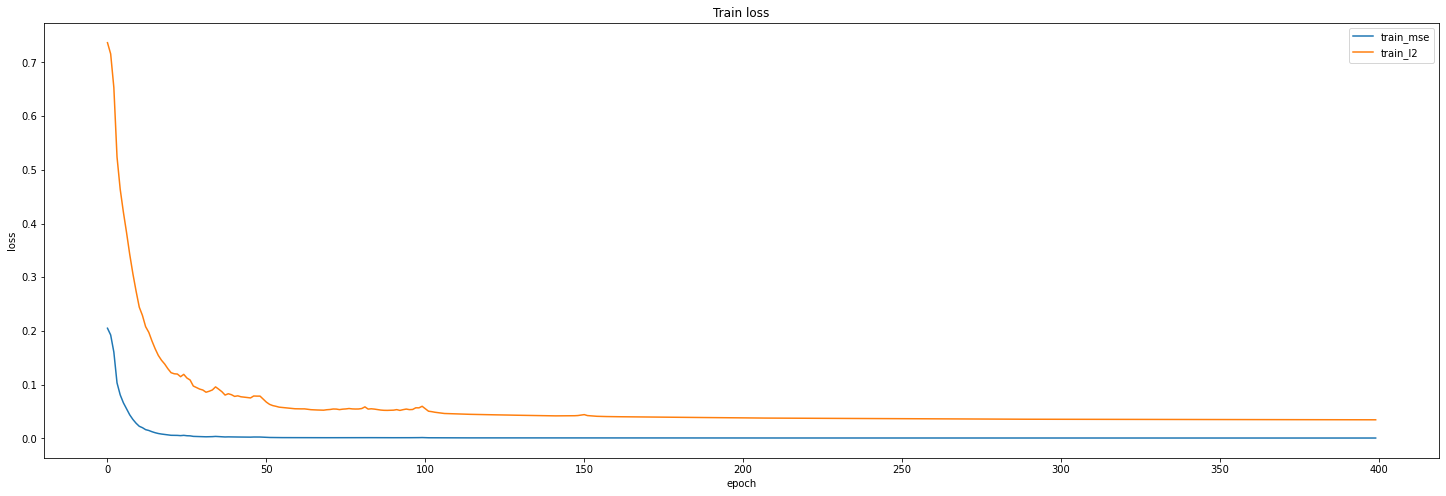

In [140]:
fig = plt.figure(figsize=(25, 8))
plt.plot(train_mse_arr, label = 'train_mse')
plt.plot(train_l2_arr, label = 'train_l2')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.title('Train loss')
plt.show()

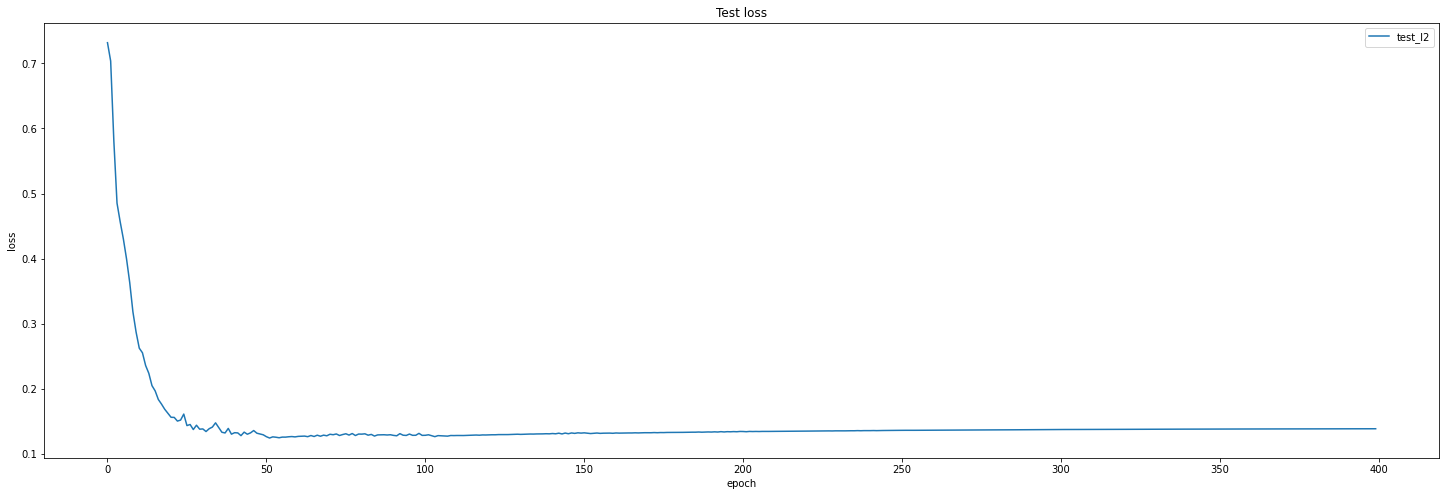

In [141]:
fig = plt.figure(figsize=(25, 8))
plt.plot(test_l2_arr, label = 'test_l2')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.title('Test loss')
plt.show()

In [142]:
out.shape

torch.Size([1, 256, 256, 29])

In [143]:
scipy.io.savemat('results/'+path+'.mat', mdict={'pred': pred.cpu().numpy()})

NameError: ignored

In [190]:
## for diff test file (ex: train on mix data, test on circ)
# #TRAIN_PATH = '/content/drive/MyDrive/LBM_data/Sqst64_data_N2500_halfway.npy'
ntrain = 8
ntest =2
#TRAIN_PATH = '/content/drive/MyDrive/LBM_data/Sqst64_data_N2500_halfway.npy'
TRAIN_PATH = '/content/Mix256_data_N10_halfway.npy'
S = 64

In [ ]:
u = np.load(TRAIN_PATH)
u = u.transpose(0, 2, 3, 1)
u.shape

(2500, 64, 64, 50)

In [ ]:
a_normalizer.mean

tensor(6.8391e-07)

In [ ]:
test_a = u[ntrain:, :, :, :T_in]
test_u = u[ntrain:, :, :, T_in:T+T_in]

test_a = torch.Tensor(test_a)
test_u = torch.Tensor(test_u)

test_a = a_normalizer.encode(test_a)

sdf = np.load('/content/drive/MyDrive/LBM_data/sdf_array_sqst64_N2500.npy')
sdf.shape
sdf = torch.from_numpy(sdf).unsqueeze(-1).float()
sdf = sdf_a_normalizer.encode(sdf)
sdf.shape
test_a = torch.cat((test_a, sdf[ntrain:]), -1)
test_a = test_a.reshape(ntest,S,S,1,T_in+1).repeat([1,1,1,T,1])
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

test_a.shape

torch.Size([500, 64, 64, 29, 2])

In [ ]:
myloss = LpLoss(size_average=False)
y_normalizer.cuda()
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(out.view(1, S, S, T))
        #print(out.shape, pred.shape)
        pred[index] = torch.squeeze(out)

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

0 0.028614703565835953
1 0.015480649657547474
2 0.026226162910461426
3 0.014546939171850681
4 0.01744375191628933
5 0.01037122868001461
6 0.02155335061252117
7 0.01225750707089901
8 0.011284077540040016
9 0.014288851991295815
10 0.012366426177322865
11 0.01050284318625927
12 0.026426684111356735
13 0.012101723812520504
14 0.018491234630346298
15 0.016241727396845818
16 0.017575638368725777
17 0.016623929142951965
18 0.014186378568410873
19 0.01864599622786045
20 0.020821981132030487
21 0.015857750549912453
22 0.015735482797026634
23 0.014744733460247517
24 0.016991451382637024
25 0.02266029454767704
26 0.015106232836842537
27 0.020505979657173157
28 0.012620857916772366
29 0.01806887798011303
30 0.017556574195623398
31 0.014374161139130592
32 0.01669725961983204
33 0.026255561038851738
34 0.013927171006798744
35 0.019067395478487015
36 0.019512498751282692
37 0.014560552313923836
38 0.026904450729489326
39 0.01788616180419922
40 0.02014504000544548
41 0.020576853305101395
42 0.01551263

In [145]:
test_a.shape

torch.Size([2, 256, 256, 29, 2])

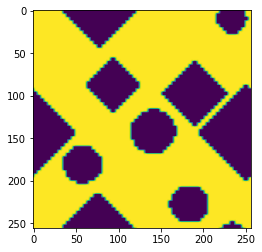

In [148]:
plt.imshow(test_a[0, :, :, 0, 0])

In [ ]:
n = 5  # which sample
T_in = 1
T = 29
step = 1
step_x = 1
dt = 1

m=8 #modes
w=32  #width
l=4 #fourier layers

In [ ]:
#u = np.load('/content/drive/MyDrive/Porous/LBM_data/LBM_data_mix_256x256_1000.npy')

In [144]:
#u = u[1700:]

In [ ]:
pred = np.array(pred)

In [ ]:
_min = min(pred[n, :, :, :].min(), u[n, :, :, T_in : T+T_in].min())
_max = max(pred[n, :, :, :].max(), u[n, :, :, T_in : T+T_in].max())

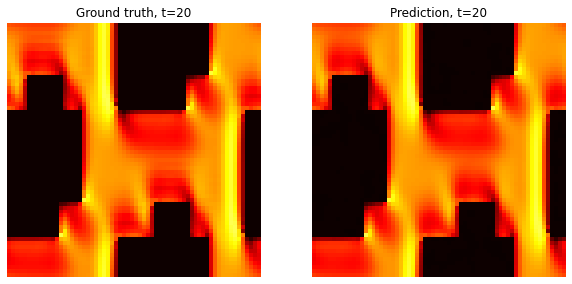

In [ ]:
frame=19

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(f'Ground truth, t={(T_in + frame)*dt}')
plt.imshow(u[ntrain+n, :, :, (T_in+frame)*step_x], vmin = _min, vmax = _max, cmap='hot')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f'Prediction, t={(T_in + frame)*dt}')
plt.imshow(pred[n, :, :, frame], vmin = _min, vmax = _max, cmap='hot')

In [ ]:
diff_min = np.absolute(pred[n, :, :, :] - u[ntrain+n, :, :, T_in : T+T_in]).min()
diff_max = np.absolute(pred[n, :, :, :] - u[ntrain+n, :, :, T_in : T+T_in]).max()

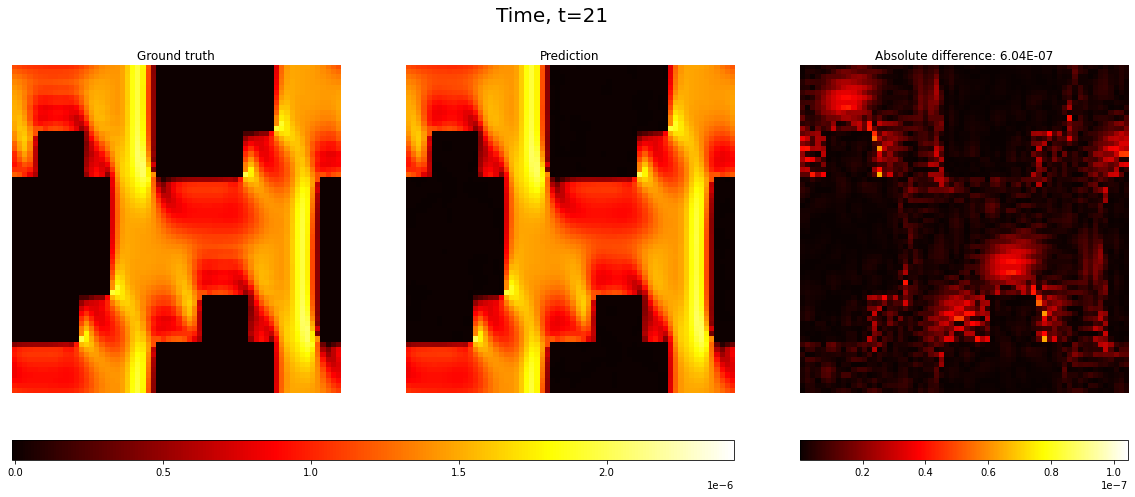

In [ ]:
frame = 20

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 7))
p0 = ax[0].get_position().get_points().flatten()
p1 = ax[1].get_position().get_points().flatten()
p2 = ax[2].get_position().get_points().flatten()

plt.suptitle(f'Time, t={(T_in + frame)*dt}', fontsize=20)
plt.subplots_adjust(top=0.95)

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title(f'Ground truth')
plt.imshow(u[ntrain+n, :, :, (T_in+frame)*step_x], vmin = _min, vmax = _max, cmap='hot')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title(f'Prediction')
im = plt.imshow(pred[n, :, :, frame], vmin = _min, vmax = _max, cmap='hot')

ax_cbar = fig.add_axes([p0[0], 0.08, p1[2]-p0[0], 0.04])
plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title(f'Absolute difference: {np.mean(np.absolute(pred[n, :, :, frame] - u[n, :, :, (T_in+frame)*step_x])):.2E}')
im = plt.imshow(np.absolute(pred[n, :, :, frame] - u[ntrain+n, :, :, (T_in+frame)*step_x]), vmin = diff_min, vmax = diff_max, cmap='hot')

ax_cbar1 = fig.add_axes([p2[0], 0.08, p2[2]-p2[0], 0.04])
plt.colorbar(im, cax=ax_cbar1, orientation='horizontal')

In [ ]:
u[n, :, :, (T_in+frame)*step_x][20]

array([1.8759138e-05, 1.8794530e-05, 1.8839874e-05, 1.8896137e-05,
       1.8963890e-05, 1.9043337e-05, 1.9134364e-05, 1.9236621e-05,
       1.9349587e-05, 1.9472654e-05, 1.9605191e-05, 1.9746618e-05,
       1.9896443e-05, 2.0054309e-05, 2.0220004e-05, 2.0393456e-05,
       2.0574727e-05, 2.0763960e-05, 2.0961355e-05, 2.1167092e-05,
       2.1381295e-05, 2.1603963e-05, 2.1834936e-05, 2.2073857e-05,
       2.2320168e-05, 2.2573118e-05, 2.2831813e-05, 2.3095281e-05,
       2.3362551e-05, 2.3632716e-05, 2.3904953e-05, 2.4178431e-05,
       2.4452109e-05, 2.4724381e-05, 2.4992651e-05, 2.5252952e-05,
       2.5499761e-05, 2.5726202e-05, 2.5924728e-05, 2.6088213e-05,
       2.6211206e-05, 2.6290971e-05, 2.6327985e-05, 2.6325730e-05,
       2.6289992e-05, 2.6227892e-05, 2.6146978e-05, 2.6054497e-05,
       2.5956942e-05, 2.5859825e-05, 2.5767600e-05, 2.5683683e-05,
       2.5610474e-05, 2.5549367e-05, 2.5500716e-05, 2.5463734e-05,
       2.5436388e-05, 2.5415269e-05, 2.5395571e-05, 2.5371193e

In [ ]:
pred[n, :, :, frame][20]

array([ 1.81524829e-05,  1.81986543e-05,  1.82505810e-05,  1.83089833e-05,
        1.83745469e-05,  1.84478977e-05,  1.85296158e-05,  1.86202251e-05,
        1.87201276e-05,  1.88295617e-05,  1.89485472e-05,  1.90768587e-05,
        1.92140869e-05,  1.93596788e-05,  1.95130633e-05,  1.96736037e-05,
        1.98406015e-05,  2.00132708e-05,  2.01908006e-05,  2.03724048e-05,
        2.05573087e-05,  2.07447774e-05,  2.09340651e-05,  2.11243532e-05,
        2.13147032e-05,  2.15039727e-05,  2.16907865e-05,  2.18735568e-05,
        2.20508591e-05,  2.22222334e-05,  2.23868810e-05,  2.25414660e-05,
        2.26829761e-05,  2.28096560e-05,  2.29204197e-05,  2.30146652e-05,
        2.30922560e-05,  2.31533522e-05,  2.31983413e-05,  2.32278981e-05,
        2.32430375e-05,  2.32450839e-05,  2.32358507e-05,  2.32166894e-05,
        2.31888916e-05,  2.31536542e-05,  2.31120466e-05,  2.30650385e-05,
        2.30134792e-05,  2.29581547e-05,  2.28997797e-05,  2.28390127e-05,
        2.27764394e-05,  

In [166]:
np.min(pred[n, :, :, frame][20])

NameError: ignored

<ipython-input-71-60dcfed2e3c1>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 7))


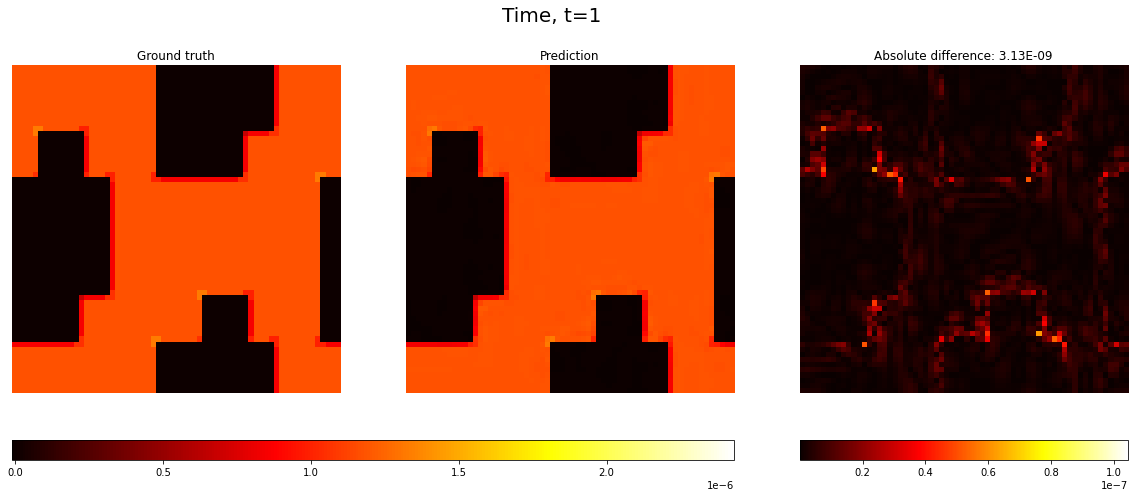

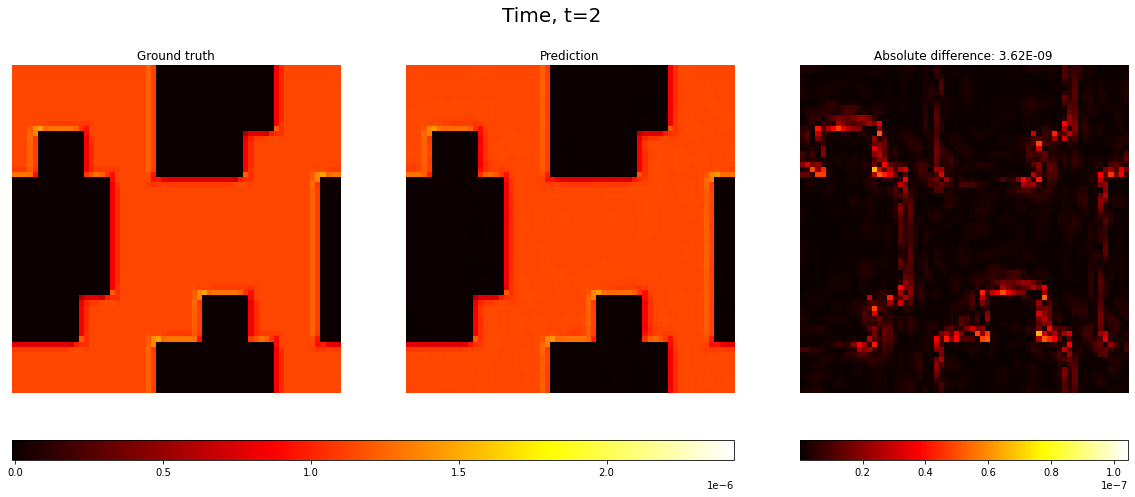

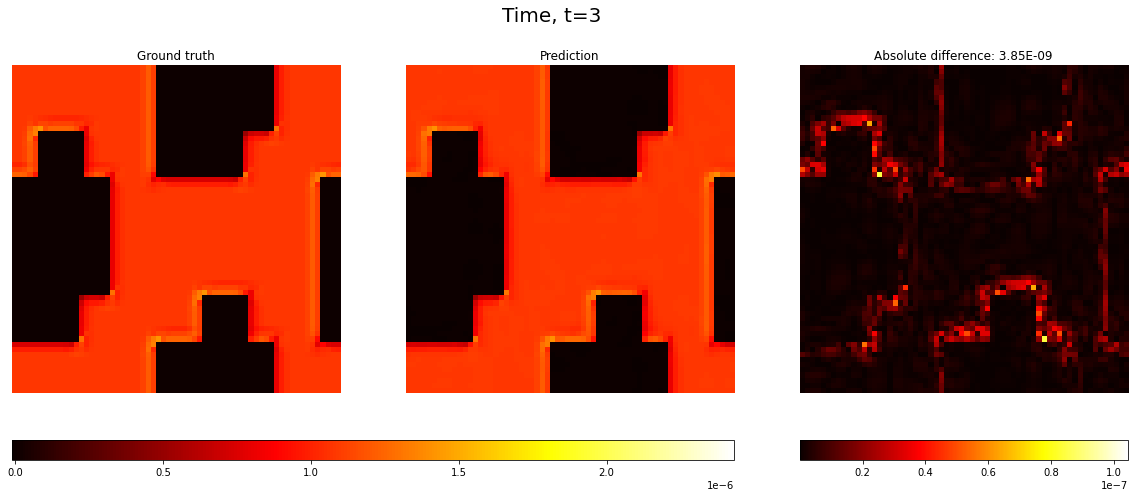

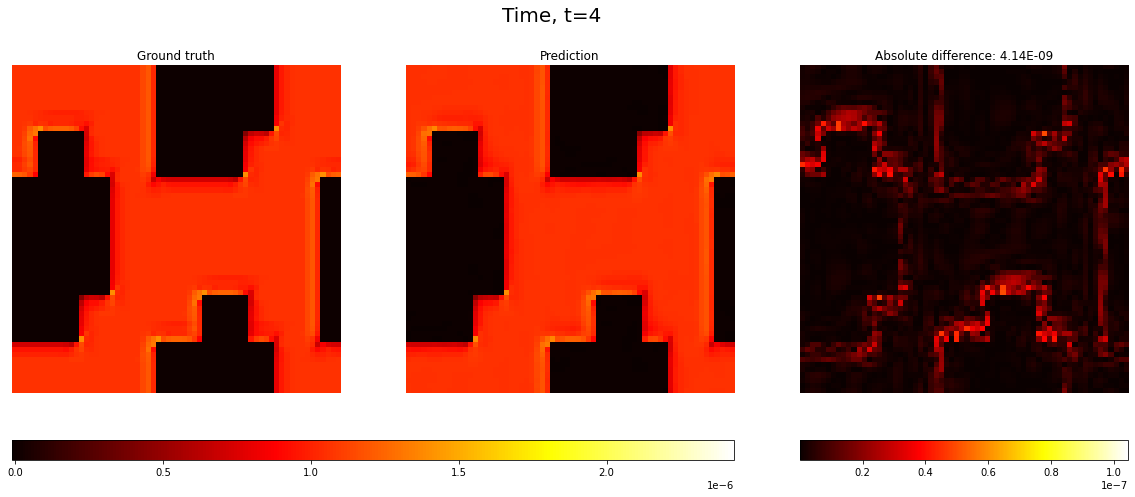

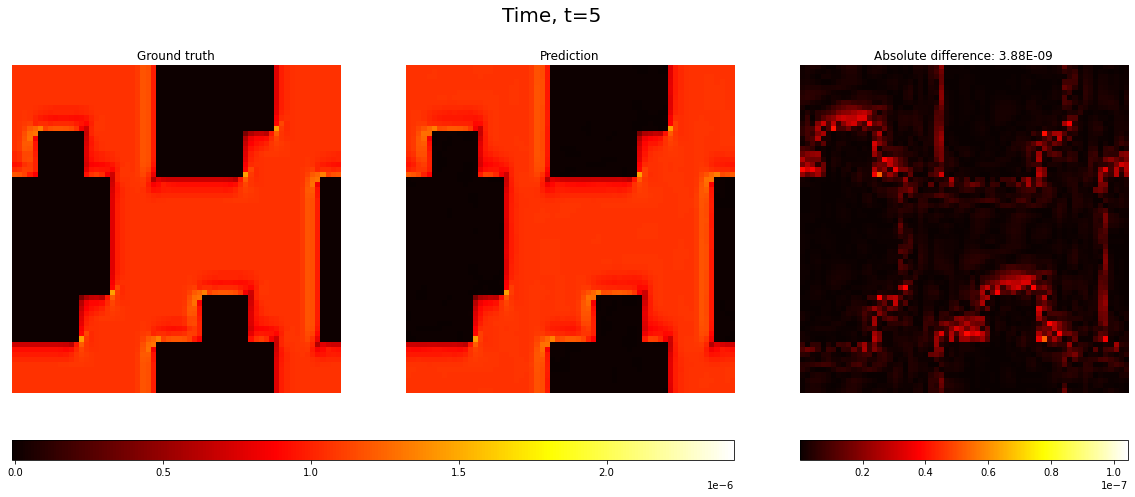

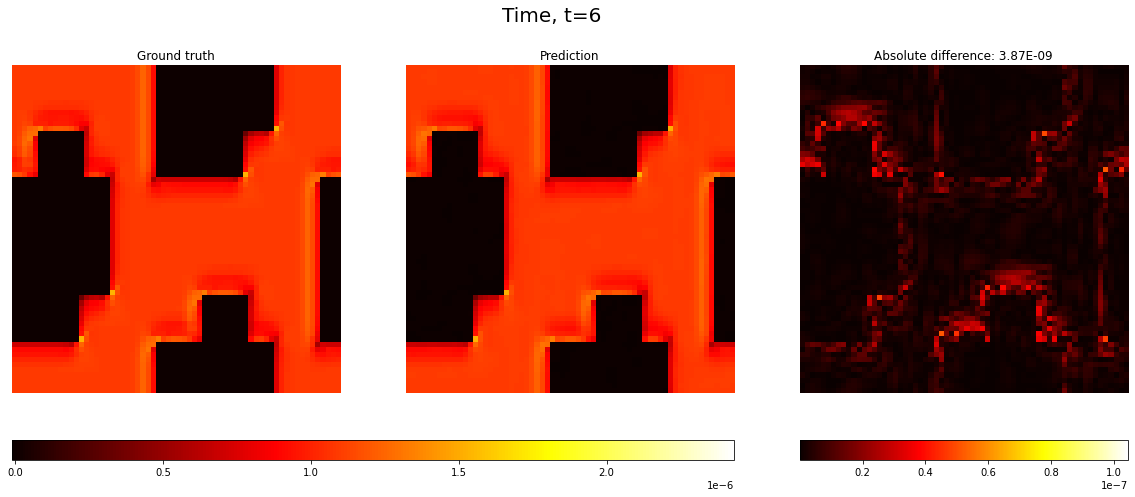

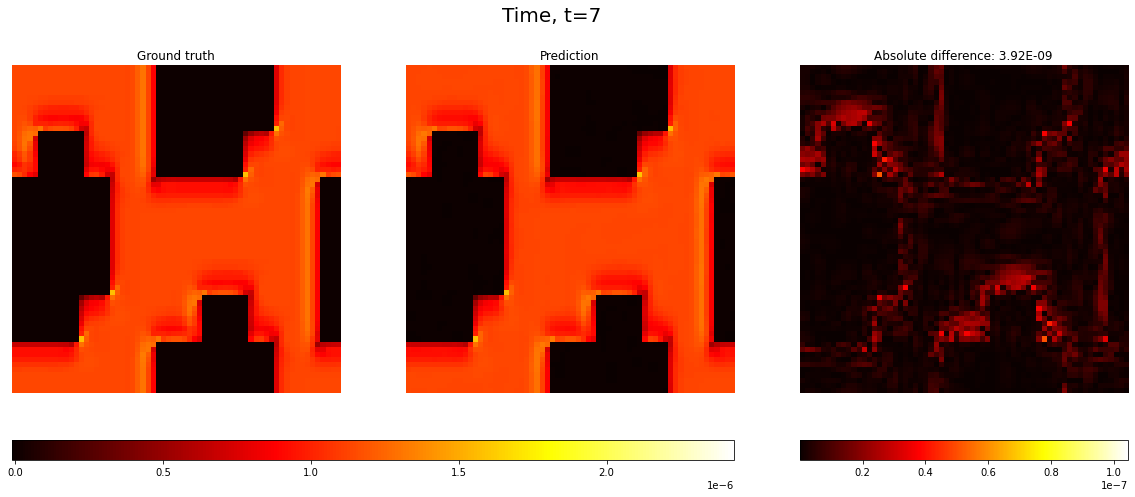

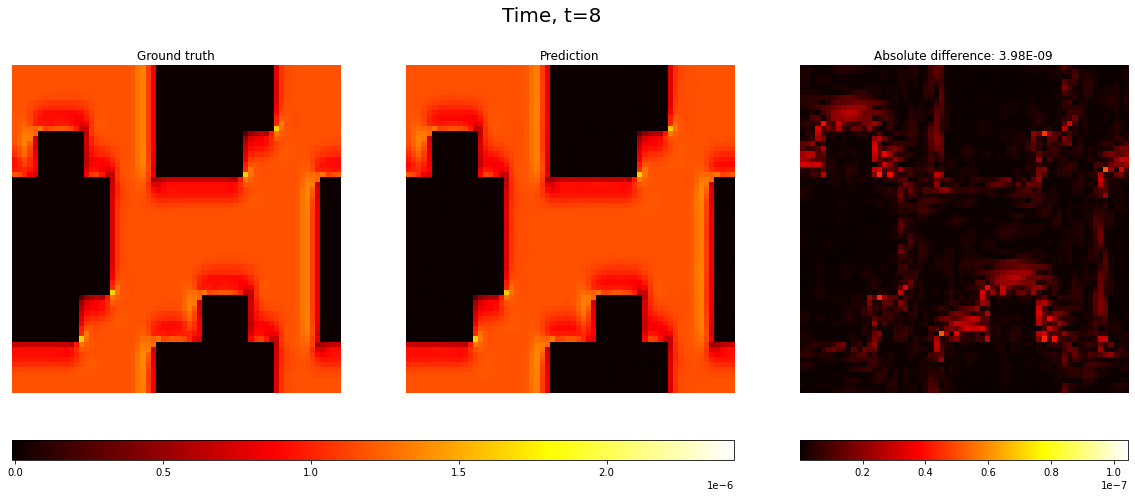

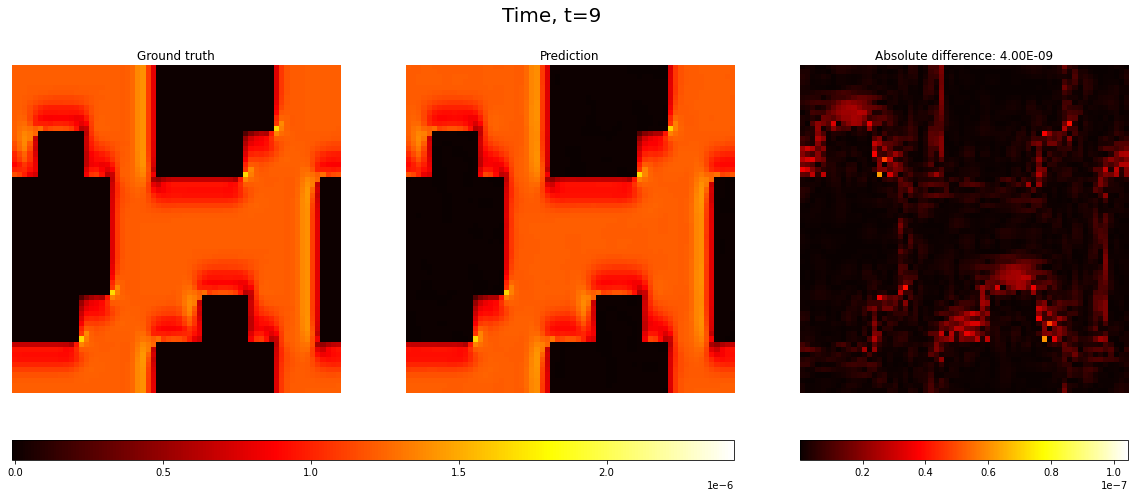

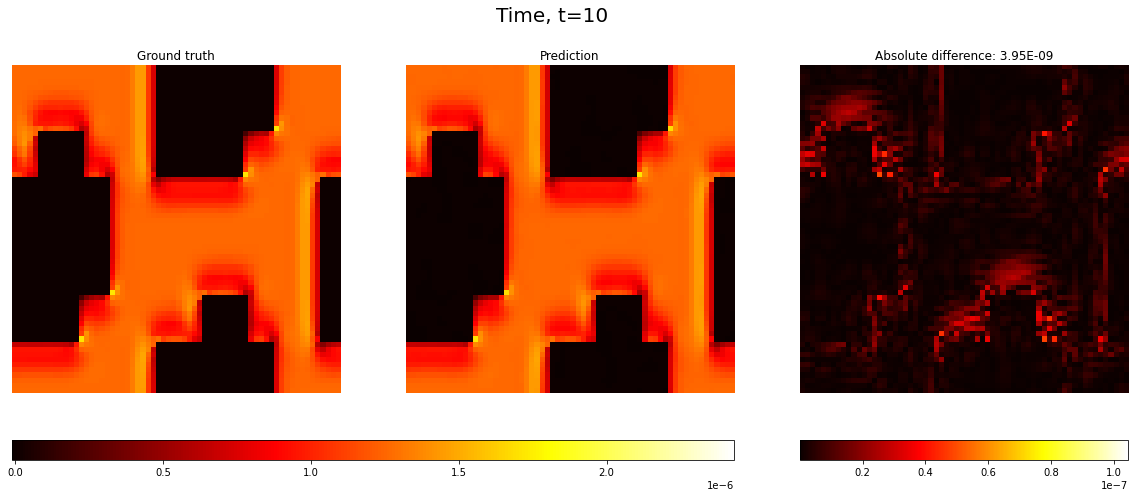

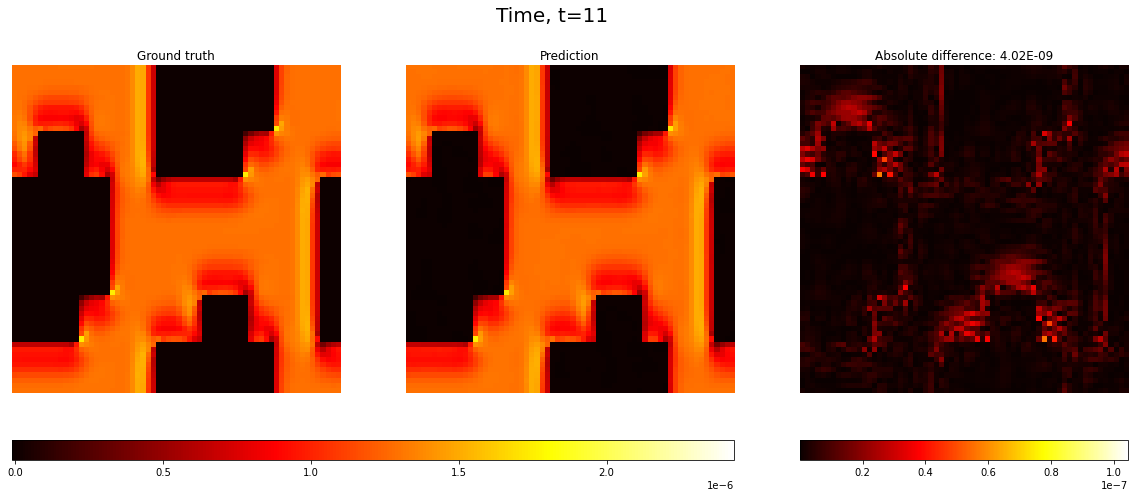

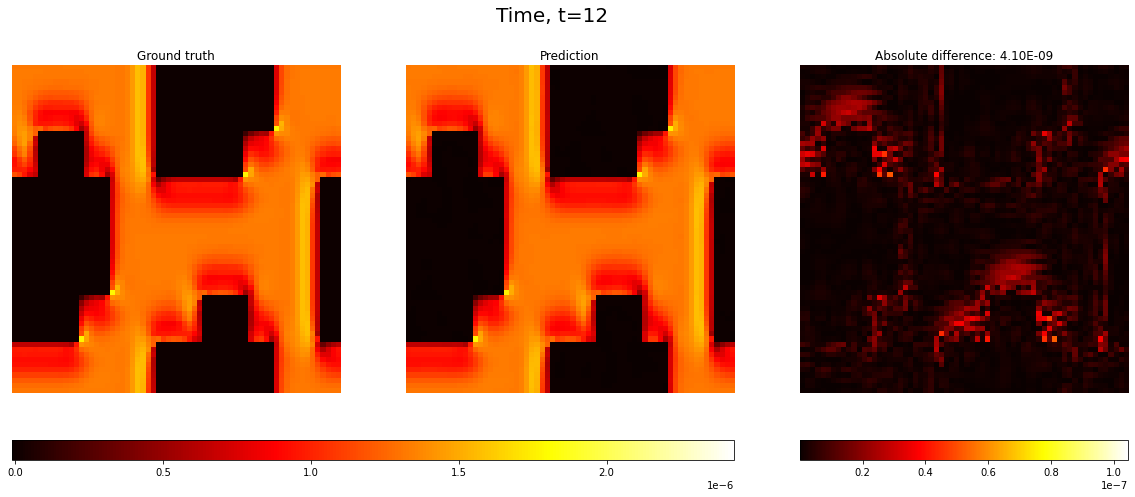

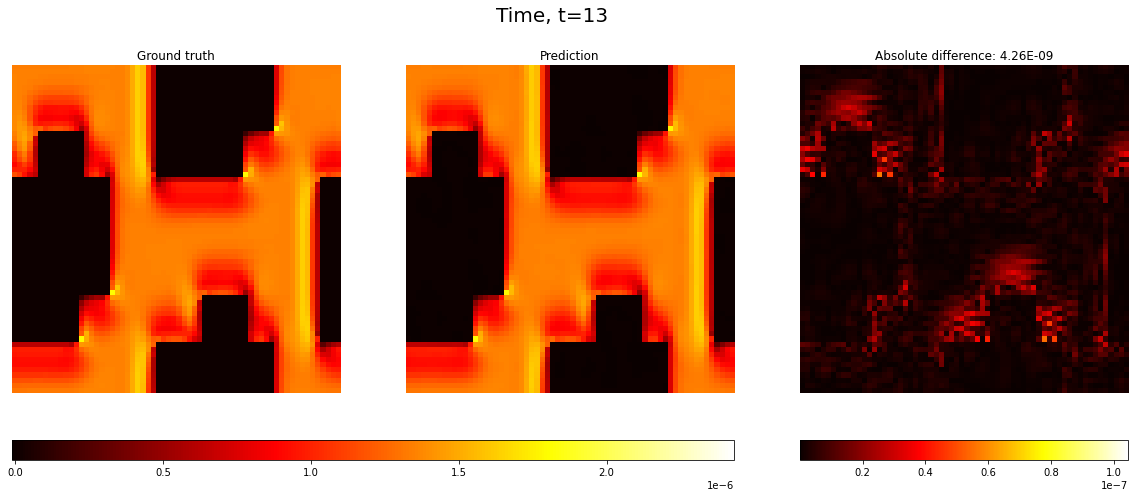

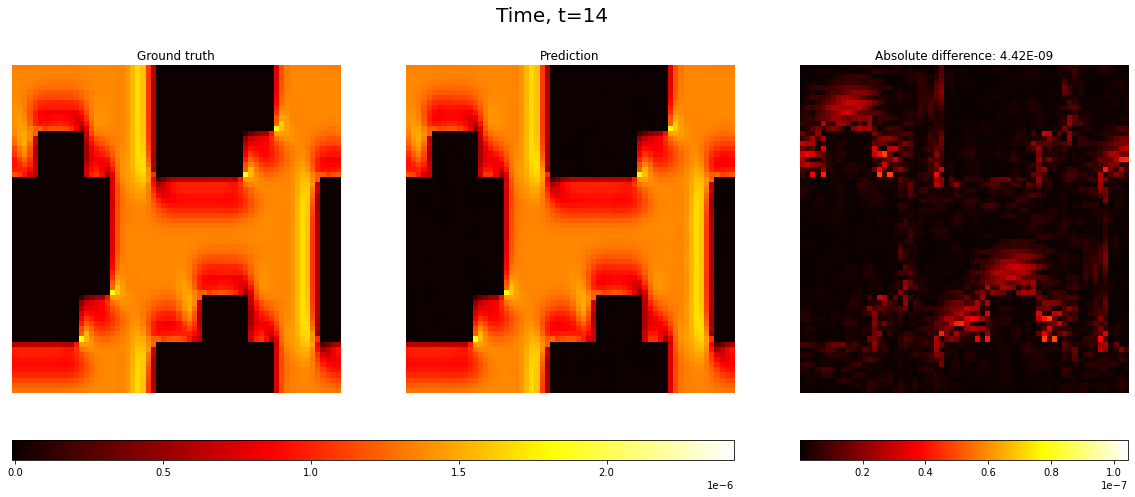

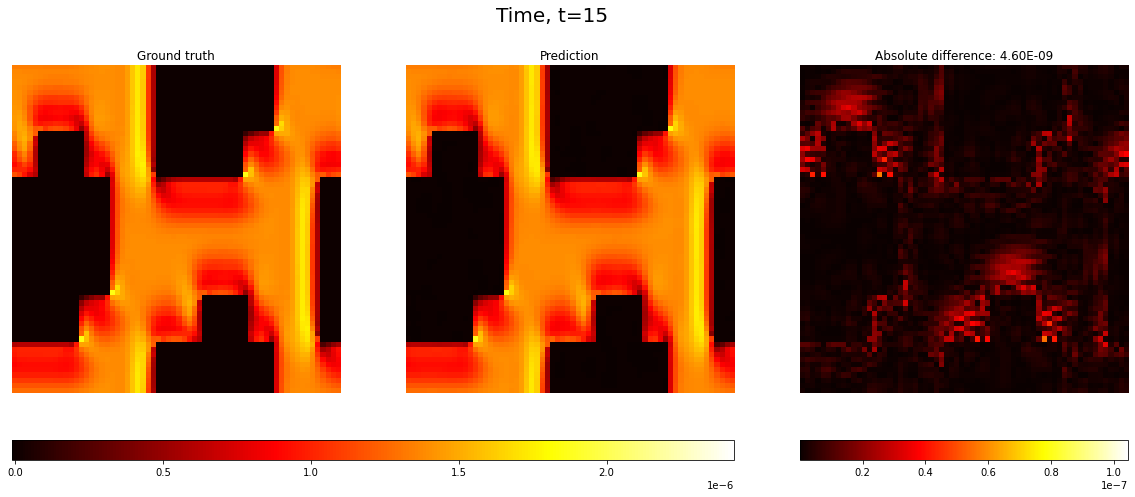

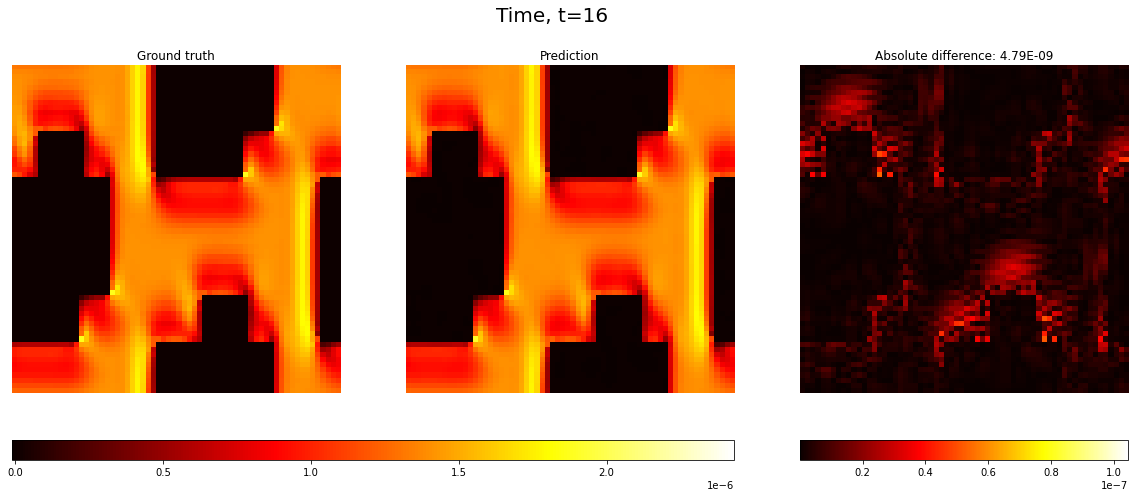

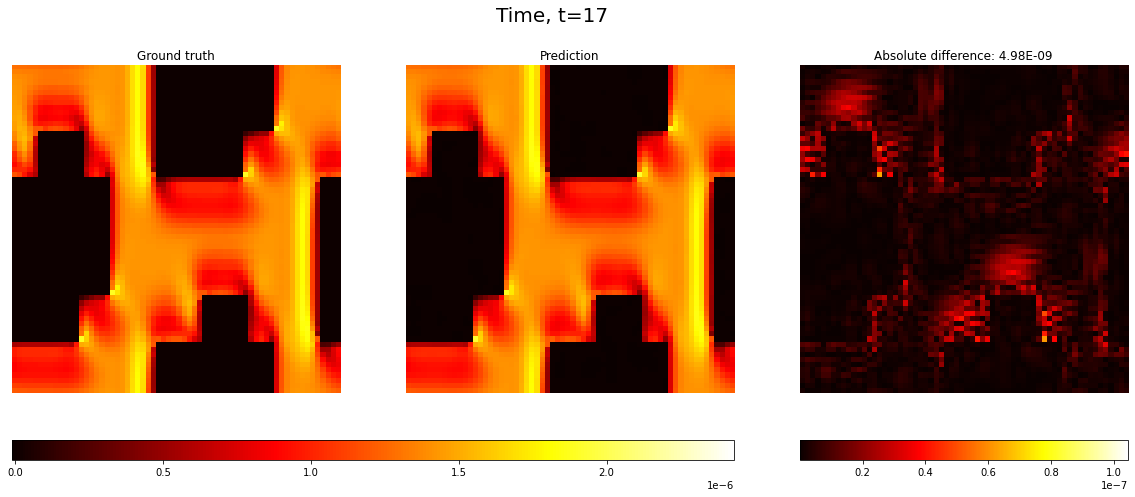

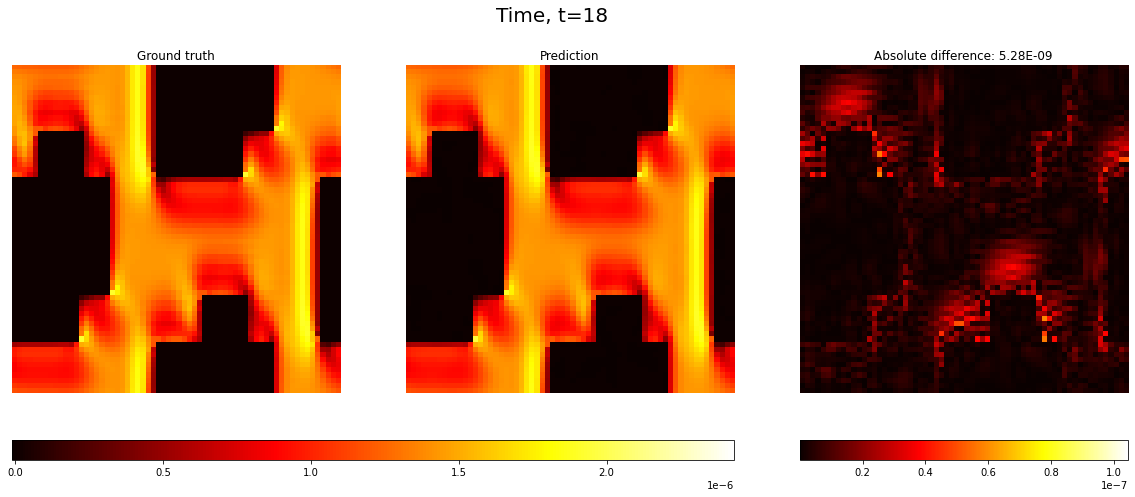

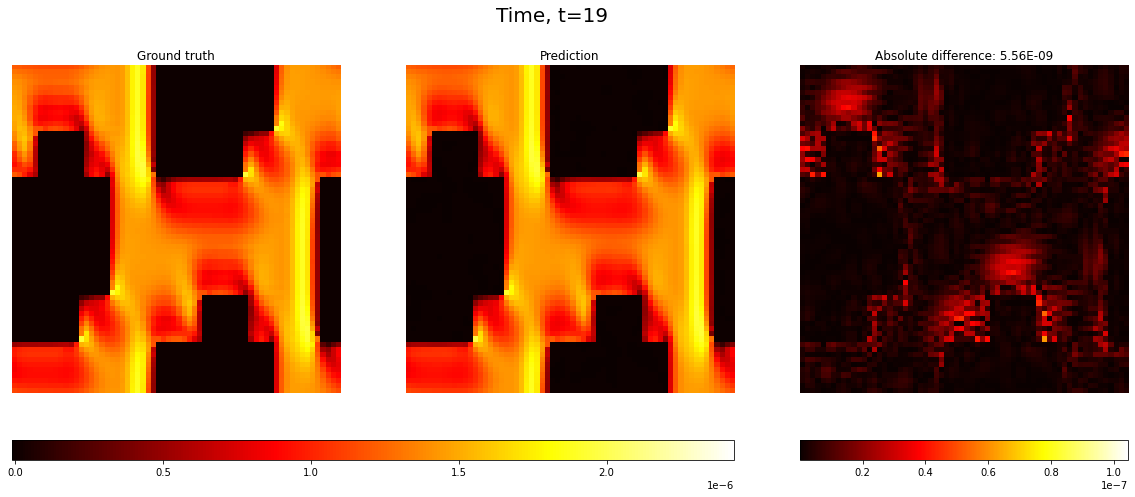

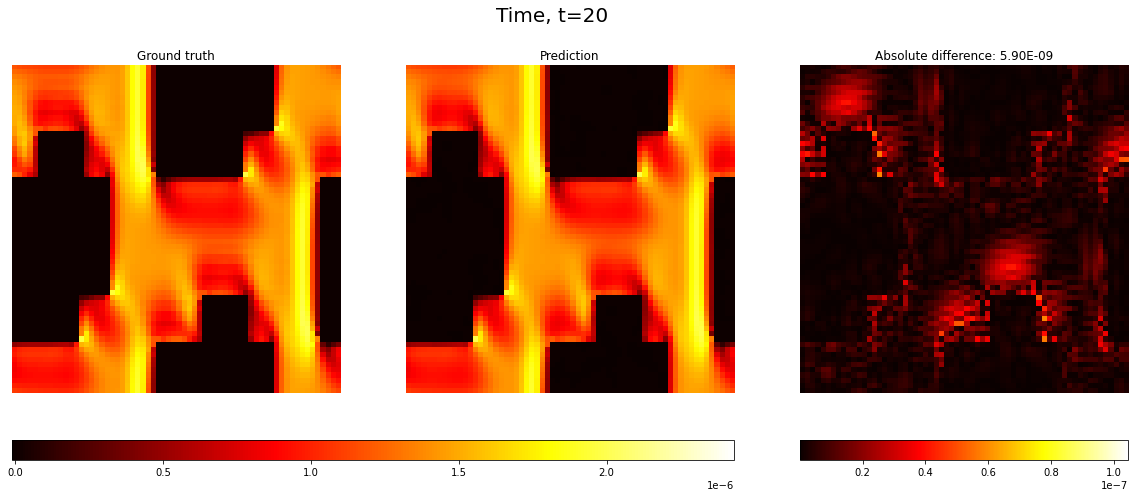

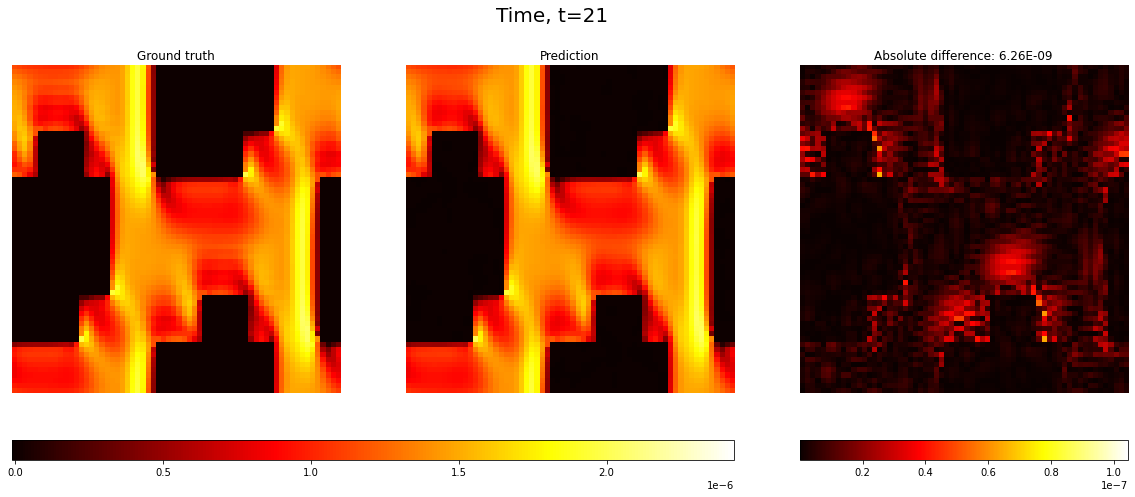

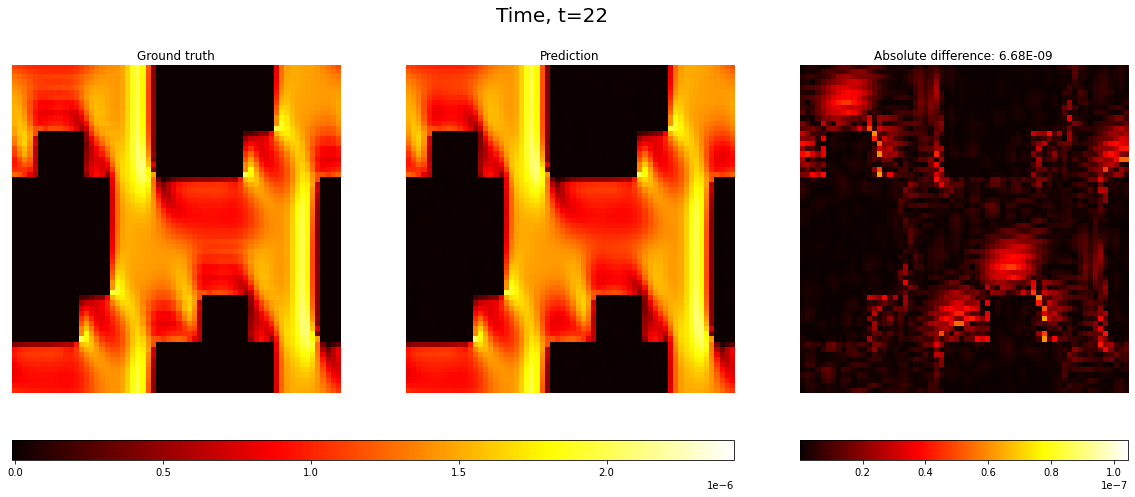

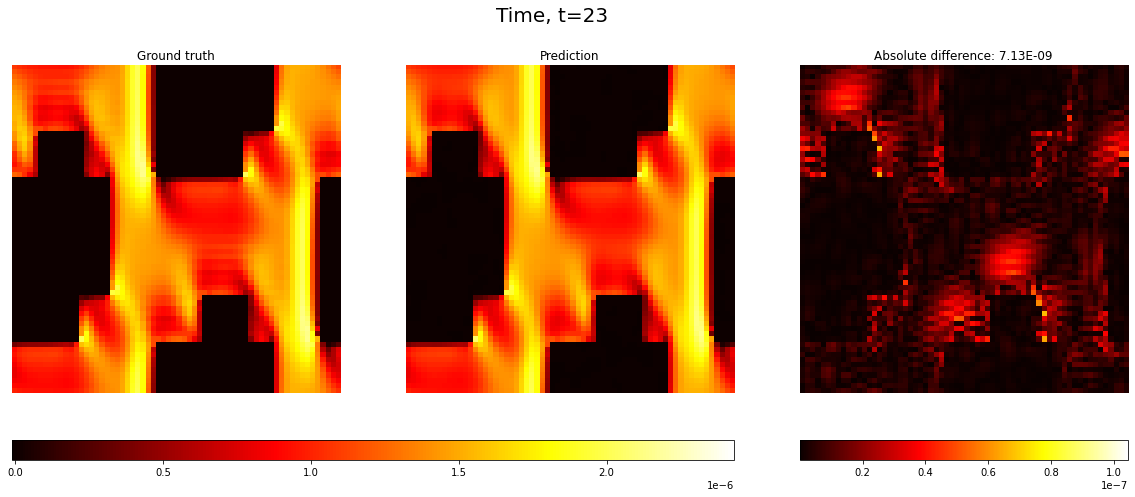

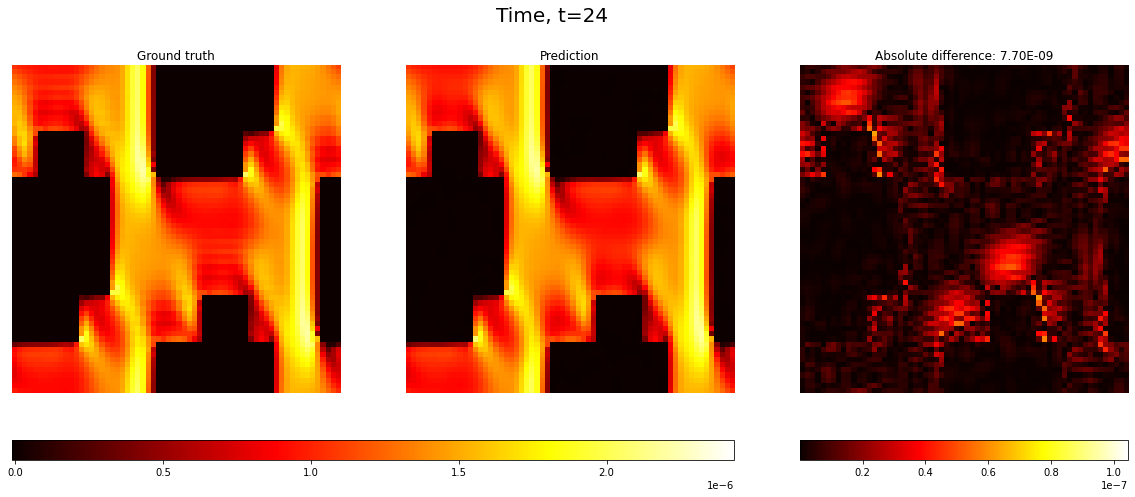

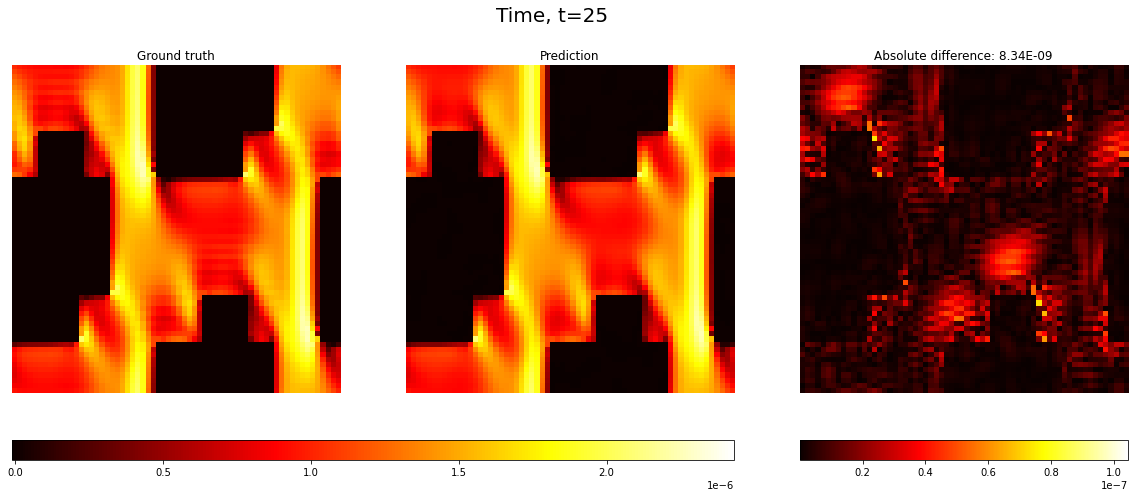

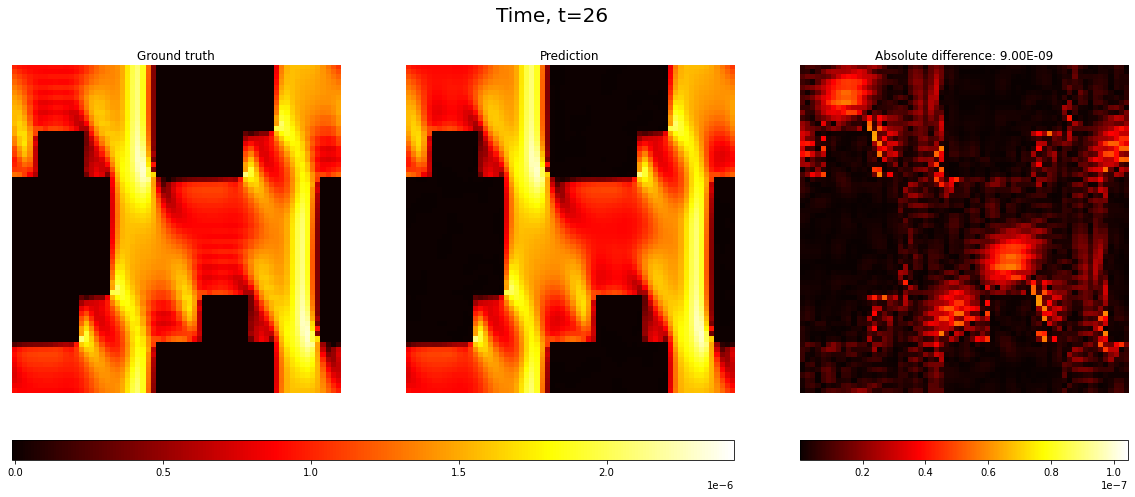

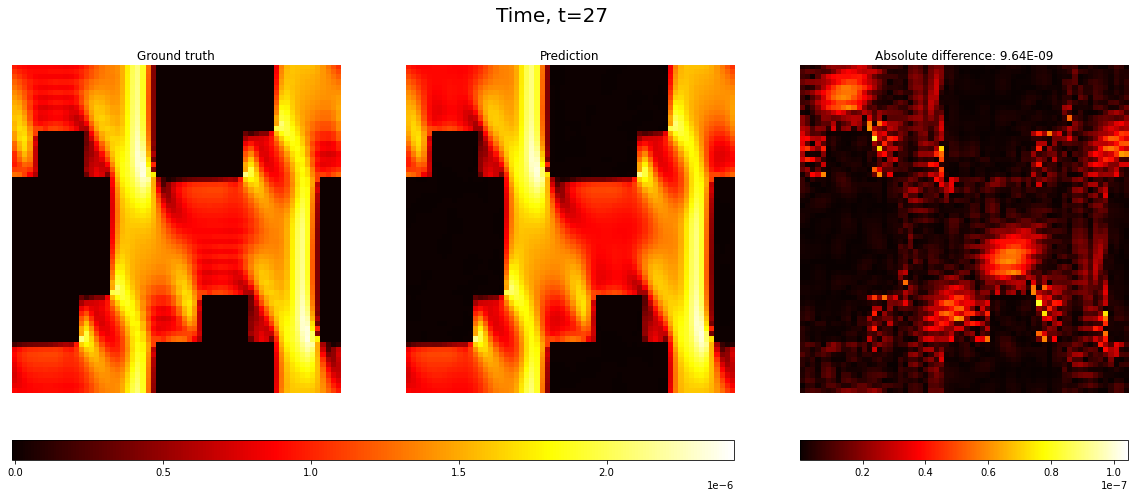

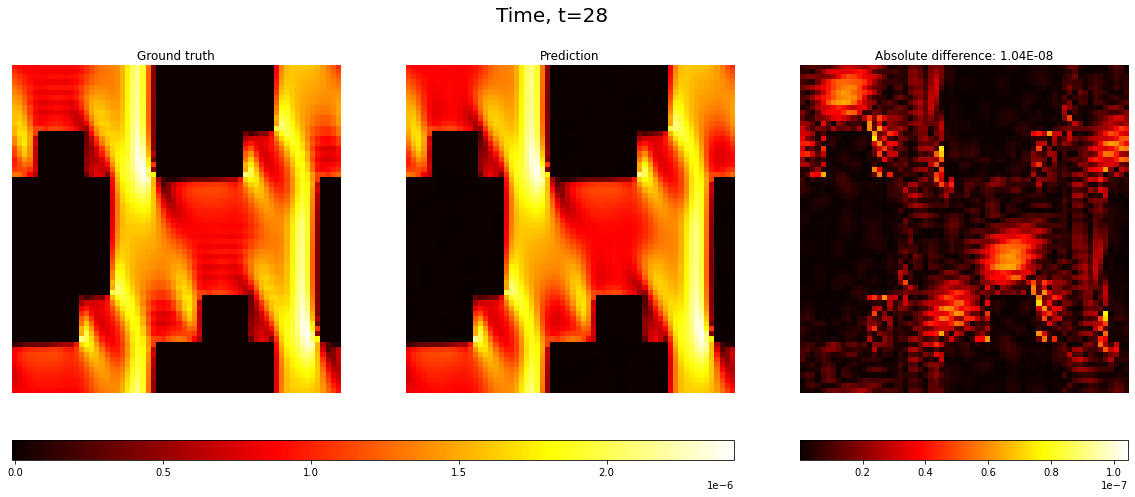

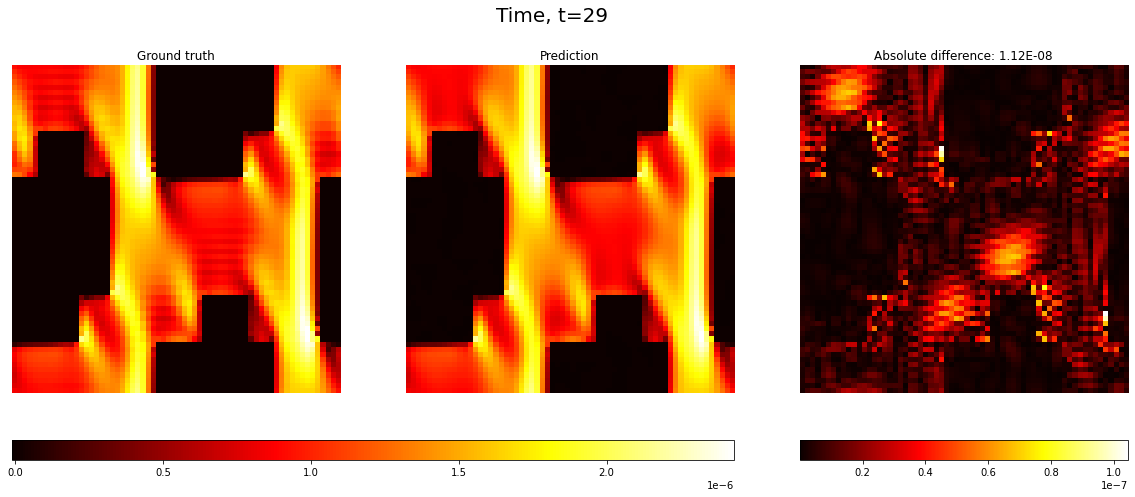

In [ ]:
import os
import shutil
#save frames as png
PATH = f'results/Animation/stsq_halfway sdf N2500_64x64_on_stsq GN rs{T+T_in} T_in {T_in} n{n} m{m} w{w} l{l}'
if os.path.exists(PATH):
  shutil.rmtree(PATH)
os.mkdir(PATH)

for frame in range(T):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 7))
  p0 = ax[0].get_position().get_points().flatten()
  p1 = ax[1].get_position().get_points().flatten()
  p2 = ax[2].get_position().get_points().flatten()

  plt.suptitle(f'Time, t={(T_in + frame)*dt}', fontsize=20)
  plt.subplots_adjust(top=0.95)

  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.title(f'Ground truth')
  plt.imshow(u[ntrain+n, :, :, (T_in+frame)*step_x], vmin = _min, vmax = _max, cmap='hot')

  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.title(f'Prediction')
  im = plt.imshow(pred[n, :, :, frame], vmin = _min, vmax = _max, cmap='hot')

  ax_cbar = fig.add_axes([p0[0], 0.08, p1[2]-p0[0], 0.04])
  plt.colorbar(im, cax=ax_cbar, orientation='horizontal')

  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.title(f'Absolute difference: {np.mean(np.absolute(pred[n, :, :, frame] - u[ntrain+n, :, :, (T_in+frame)*step_x])):.2E}')
  im = plt.imshow(np.absolute(pred[n, :, :, frame] - u[ntrain+n, :, :, (T_in+frame)*step_x]), vmin = diff_min, vmax = diff_max, cmap='hot')

  ax_cbar1 = fig.add_axes([p2[0], 0.08, p2[2]-p2[0], 0.04])
  plt.colorbar(im, cax=ax_cbar1, orientation='horizontal')

  plt.savefig(PATH + f'/{frame}')

In [ ]:
from PIL import Image
# make list of images
imlist = []
paths = [PATH]
for path in paths:
  ar = []
  for i in os.listdir(path):
    f = os.path.join(path, i)
    ar.append(Image.open(f).convert('RGB').convert('P', palette=Image.ADAPTIVE))
  imlist.append(ar)

In [ ]:
#save gif
j=0
for path in paths:
  imlist[j][0].save(path+'.gif',
                save_all=True,
                append_images=imlist[j][1:],
                duration=300,
                loop=0)
  j=j+1;

In [ ]:
train_a.shape, train_u.shape

(torch.Size([2000, 64, 64, 1]), torch.Size([2000, 64, 64, 29]))

In [ ]:
torch.mean(train_u, 0).shape

torch.Size([64, 64, 29])